# Assignment 4

**Submission deadline: last lab session before or on Wednesday, 22.11.17**

**Points: 11 + 4 bonus points**


## Downloading this notebook

This assignment is an Jupyter notebook. Download it by cloning https://github.com/janchorowski/nn_assignments. Follow the instructions in its README for instructions.

Please do not hesitate to use GitHub’s pull requests to send us corrections!

# Starter code: network for Irises in Pytorch


In the following cells a feedforward neural network has been implemented with the aid of PyTorch and its autograd mechanism. Please study the code - many network implementations follow a similar pattern.

The provided network trains to nearly 100% accuracy on Iris using Batch Gradient Descent.

In [2]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [3]:
import numpy as np
import torch
import torch.nn.functional as F
from torch.autograd import Variable


class Layer(object):
    
    def train_mode(self):
        """Put layer into training mode.
        """
        self.mode = "train"
    
    def eval_mode(self):
        """Put layer into evalation mode.
        """
        self.mode = "eval"
    
    @property
    def parameters(self):
        return []
    

class AffineLayer(Layer):
    def __init__(self, num_in, num_out):
        self.W = Variable(torch.FloatTensor(num_in, num_out),
                          requires_grad=True)
        self.W.name = 'W'
        self.b = Variable(torch.FloatTensor(1, num_out),
                          requires_grad=True)
        self.b.name = 'b'
    
    @property
    def parameters(self):
        return [self.W, self.b]
    
    def forward(self, x):
        return x.mm(self.W) + self.b

    
class TanhLayer(Layer):
    def forward(self, x):
        return F.tanh(x)

    
class  ReLULayer(Layer):
    def forward(self, x):
        return F.relu(x)


class SoftMaxLayer(Layer):
    def forward(self, x):
        return F.softmax(x)
    
class DropoutLayer(Layer):
    def forward(self, x):
        if self.mode == "train":
            return torch.nn.functional.dropout(x, 0.5, training=True)
        return torch.nn.functional.dropout(x, 0.5, training=False)
class DropoutLayer20(Layer):
    def forward(self, x):
        if self.mode == "train":
            return torch.nn.functional.dropout(x, 0.2, training=True)
        return torch.nn.functional.dropout(x, 0.2, training=False)
    
class ConvLayer(Layer):
    def __init__(self,in_channels, out_channels,height, width, padding=True):
        self.W = Variable(torch.FloatTensor(out_channels, in_channels, height, width), requires_grad=True)
        self.b = Variable(torch.FloatTensor(out_channels), requires_grad=True)
        self.W.name = "Wconv"
        self.b.name = "b"
        self.padding = padding
        
    @property
    def parameters(self):
        return [self.W, self.b]
    
    def forward(self, x):
        if self.padding:
            padH = (self.W.size(2) - 1)/2
            padW = (self.W.size(3) - 1)/2
        else:
            padH = 0
            padW = 0
        batch_size = x.size(0)
        in_channel_size = self.W.size(1)
        out_channel_size = self.W.size(0)
    
        #print self.W
        hw = int(math.sqrt(x.size(1)/in_channel_size))
        res =  F.conv2d(x.view(batch_size, in_channel_size, hw, hw), self.W, self.b, padding=(padH, padW))
        #print self.b
        return res.view(batch_size, -1)
    
class MaxPoolLayer(Layer):
    def __init__(self, kernel_size, channels):
        self.kernel_size = kernel_size
        self.channels = channels
    
    def forward(self, x):
        batch_size = x.size(0)
        hw = int(math.sqrt(x.size(1)/self.channels))
        res = F.max_pool2d(x.view(batch_size, self.channels, hw, hw), self.kernel_size)
        return res.view(batch_size, -1)
    
class BatchNormLayer(Layer):
    def __init__(self, num_in):
        self.iter = 0.0
        self.test_u = torch.Tensor(1, num_in)
        self.test_sigma = torch.Tensor(1, num_in)
        self.gamma = Variable(torch.ones(1, num_in), requires_grad=True)
        self.beta = Variable(torch.zeros(1, num_in), requires_grad=True)
        self.gamma.name = "W"
        self.beta.name = "b"
    
    @property
    def parameters(self):
        return [self.gamma, self.beta]
            
    def forward(self, x):
        if self.gamma.is_cuda and not self.test_u.is_cuda:
            self.test_u = self.test_u.cuda()
            self.test_sigma = self.test_sigma.cuda()
        
        if not self.gamma.is_cuda and self.test_u.is_cuda:
            self.test_u = self.test_u.cpu()
            self.test_sigma = self.test_sigma.cpu()
        
        if self.mode == "train":
            self.iter += 1.0
            u = torch.mean(x, 0, True)
            sigma_square = torch.mean((x - u) ** 2, 0, True)
            sigma = torch.sqrt(sigma_square + 10e-5)
            
            self.test_u = ( self.test_u*(self.iter-1.0) + u.data )/self.iter
            self.test_sigma = ( self.test_sigma*(self.iter-1.0) + sigma.data )/self.iter
        else:
            u = Variable(self.test_u,requires_grad=True)
            sigma = Variable(self.test_sigma,requires_grad=True)
            return self.beta + self.gamma*(x - u)/sigma
        return self.beta + self.gamma*(x - u)/sigma

In [4]:
class FeedforwardNet(object):
    def __init__(self, layers):
        self.layers = layers

    @property
    def parameters(self):
        params = []
        for layer in self.layers:
            params += layer.parameters
        return params

    @parameters.setter
    def parameters(self, values):
        for ownP, newP in zip(self.parameters, values):
            ownP.data = newP.data
    
    def train_mode(self):
        for layer in self.layers:
            layer.train_mode()
    
    def eval_mode(self):
        for layer in self.layers:
            layer.eval_mode()    
    
    def forward(self, x):
        for layer in self.layers:
            x = layer.forward(x)
        return x
    
    def loss(self, outputs, targets):
        return torch.mean(-torch.log(torch.gather(
            outputs, 1, targets.unsqueeze(1))))

In [5]:
from sklearn import datasets
import torchvision


iris = datasets.load_iris()
IrisX = iris.data.astype(np.float32)
IrisX = (IrisX - IrisX.mean(axis=0, keepdims=True)) / IrisX.std(axis=0, keepdims=True)
IrisY = iris.target

def GD(model, x, y, alpha=1e-4, max_iters=1000000, tolerance=1e-6):
    """Simple batch gradient descent"""
    try:
        old_loss = np.inf
        x = Variable(torch.from_numpy(x), requires_grad=False)
        y = Variable(torch.from_numpy(y.astype(np.int64)), requires_grad=False)
        model.train_mode()
        for i in xrange(max_iters):
            outputs = model.forward(x)
            loss = model.loss(outputs, y)

            loss.backward()
            for p in model.parameters:
                p.data -= p.grad.data * alpha
                # Zero gradients for the next iteration
                p.grad.data.zero_()

            loss = loss.data[0]
            if old_loss < loss:
                print "Iter: %d, loss increased!" % (i,)
            if (old_loss - loss) < tolerance:
                print "Tolerance level reached. Exiting."
                break
            if i % 1000 == 0:
                _, predictions = outputs.data.max(dim=1)
                err_rate = 100.0 * (predictions != y.data).sum() / outputs.size(0)
                print "Iteration {0: >6} | loss {1: >5.2f} | err rate  {2: >5.2f}%" \
                      .format(i, loss, err_rate)
            old_loss = loss
    except KeyboardInterrupt:
        pass

In [5]:
model = FeedforwardNet(
    [AffineLayer(4, 10),
     TanhLayer(),
     AffineLayer(10, 3),
     SoftMaxLayer(),
    ])

# Initialize parameters
for p in model.parameters:
    if p.name == 'W':
        # p.data.normal_(0, 0.05)
        p.data.uniform_(-0.1, 0.1)
    elif p.name == 'b':
        p.data.zero_()
    else:
        raise ValueError('Unknown parameter name "%s"' % p.name)

# Train
GD(model, IrisX, IrisY, alpha=1e-1, tolerance=1e-7)

Iteration      0 | loss  1.10 | err rate  58.00%
Iteration   1000 | loss  0.06 | err rate   2.00%
Iteration   2000 | loss  0.04 | err rate   2.00%


# Starter code for MNIST and SGD scaffolding

In [6]:
import torch
import torchvision
import os

batch_size = 128
data_path = os.environ.get('PYTORCH_DATA_PATH', '../data')

transform = torchvision.transforms.Compose(
    [torchvision.transforms.ToTensor(),
     torchvision.transforms.Normalize((0.1307,), (0.3081,)),
    ])

_test = torchvision.datasets.MNIST(
    data_path, train=False, download=True, transform=transform)

# Load training data, split into train and valid sets
_train = torchvision.datasets.MNIST(
    data_path, train=True, download=True, transform=transform)
_train.train_data = _train.train_data[:50000]
_train.train_labels = _train.train_labels[:50000]

_valid = torchvision.datasets.MNIST(
    data_path, train=True, download=True, transform=transform)
_valid.train_data = _valid.train_data[50000:]
_valid.train_labels = _valid.train_labels[50000:]

mnist_loaders = {
    'train': torch.utils.data.DataLoader(
        _train, batch_size=batch_size, shuffle=True),
    'valid': torch.utils.data.DataLoader(
        _valid, batch_size=batch_size, shuffle=False),
    'test': torch.utils.data.DataLoader(
        _test, batch_size=batch_size, shuffle=False)}


( 0 , 0 ,.,.) = 
 -0.4242 -0.4242 -0.4242  ...  -0.4242 -0.4242 -0.4242
 -0.4242 -0.4242 -0.4242  ...  -0.4242 -0.4242 -0.4242
 -0.4242 -0.4242 -0.4242  ...  -0.4242 -0.4242 -0.4242
           ...             ⋱             ...          
 -0.4242 -0.4242 -0.4242  ...  -0.4242 -0.4242 -0.4242
 -0.4242 -0.4242 -0.4242  ...  -0.4242 -0.4242 -0.4242
 -0.4242 -0.4242 -0.4242  ...  -0.4242 -0.4242 -0.4242
      ⋮  

( 1 , 0 ,.,.) = 
 -0.4242 -0.4242 -0.4242  ...  -0.4242 -0.4242 -0.4242
 -0.4242 -0.4242 -0.4242  ...  -0.4242 -0.4242 -0.4242
 -0.4242 -0.4242 -0.4242  ...  -0.4242 -0.4242 -0.4242
           ...             ⋱             ...          
 -0.4242 -0.4242 -0.4242  ...  -0.4242 -0.4242 -0.4242
 -0.4242 -0.4242 -0.4242  ...  -0.4242 -0.4242 -0.4242
 -0.4242 -0.4242 -0.4242  ...  -0.4242 -0.4242 -0.4242
      ⋮  

( 2 , 0 ,.,.) = 
 -0.4242 -0.4242 -0.4242  ...  -0.4242 -0.4242 -0.4242
 -0.4242 -0.4242 -0.4242  ...  -0.4242 -0.4242 -0.4242
 -0.4242 -0.4242 -0.4242  ...  -0.4242 -0.4242

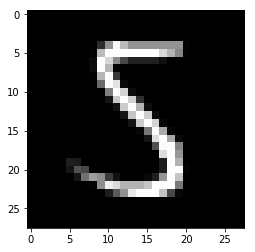

In [10]:
## DATA AUGMENTATION

from PIL import Image
from PIL import ImageFilter
import torch
import torchvision
import os
import numpy as np


def random_transform(img):
    if np.random.rand() < 0.5:
        img = img.rotate(np.random.rand()*20)
    if np.random.rand() < 0.5:
        img = img.filter(ImageFilter.GaussianBlur(np.random.rand()*0.3))
        
    
    return img
    
aug_transform = torchvision.transforms.Compose(
[
    torchvision.transforms.ToPILImage(),
    torchvision.transforms.Lambda(random_transform),
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize((0.1307,), (0.3081,))
])

def augment_data(x):
    x_size = x.size()[0]
    indicies = np.random.randint(x_size, size = x_size/2)
    
    for ind in indicies:
        x[ind] = aug_transform(x[ind])
        #plt.figure()
        #plt.imshow(x[ind][0].numpy(), cmap='gray')
    return x

i = 0
for x, y in mnist_loaders['train']:
    i = i + 1
    if i == 2:
        break
    augment_data(x)
    print x
    plt.figure()
    plt.imshow(x[0][0].numpy(), cmap='gray')

In [7]:
def compute_error_rate(model, data_loader, cuda=False):
    model.eval_mode()
    num_errs = 0.0
    num_examples = 0
    for x, y in data_loader:
        if cuda:
            x = x.cuda()
            y = y.cuda()
        x = Variable(x.view(x.size(0), -1), volatile=True)
        y = Variable(y, volatile=True)
        outputs = model.forward(x)
        _, predictions = outputs.data.max(dim=1)
        num_errs += (predictions != y.data).sum()
        num_examples += x.size(0)
    return 100.0 * num_errs / num_examples

def SGD(model, data_loaders, alpha=1e-4, alpha_decrease=0.99996, num_epochs=1, patience_expansion=1.5,
        log_every=100, cuda=False, weight_decay_rate=0.0, data_augment=False,
        epsilon_start=0.5, epsilon_100=0.9, max_norm_len=0.0):
    alpha_begin = alpha
    if cuda:
        for p in model.parameters:
            p.data = p.data.cuda()
    #
    # TODO: Initialize momentum variables
    # Hint: You need one velocity matrix for each parameter
    #
    # velocities = 
    #
    velocities = [torch.zeros(param.size()) for param in model.parameters ]
    if cuda:
        velocities = [v.cuda() for v in velocities]   
        
    epsilon = epsilon_start
    
    iter_ = 0
    epoch = 0
    best_params = None
    best_val_err = np.inf
    history = {'train_losses': [], 'train_errs': [], 'val_errs': []}
    print('Training the model!')
    print('Interrupt at any time to evaluate the best validation model so far.')
    try:
        while epoch < num_epochs:
            model.train_mode()
            epoch += 1
            for x, y in data_loaders['train']:
                
                if data_augment:
                    x = augment_data(x)
                
                if cuda:
                    x = x.cuda()
                    y = y.cuda()
                iter_ += 1
                x = Variable(x.view(x.size(0), -1), requires_grad=False)
                y = Variable(y, requires_grad=False)
                
                out = model.forward(x)
                loss = model.loss(out, y)
                loss.backward()
                _, predictions = out.data.max(dim=1)
                err_rate = 100.0 * (predictions != y.data).sum() / out.size(0)

                history['train_losses'].append(loss.data[0])
                history['train_errs'].append(err_rate)
                #
                # TODO: Update learning rate
                # Hint: Use the iteration counter i
                # alpha = TODO
                #
                
                #if alpha > 7*1e-3:
                alpha = alpha*alpha_decrease
                        
                for p, v in zip(model.parameters, velocities):
                    #
                    # TODO: Implement weight decay addition to gradients
                    # p.grad.data += TODO
                    # 
                    p.grad.data += weight_decay_rate*p.data
                    #
                    # TODO: Set the momentum constant 
                    # epsilon = TODO
                    #
                    if iter_ == 100:
                        epsilon = epsilon_100
                
                    #
                    # TODO: Implement velocity update in momentum
                    # v[...] = TODO
                    #
                    #print v
                    v[...] = epsilon*v + p.grad.data
                    
                    #
                    # TODO: Set a more sensible learning rule here,
                    #       using your learning rate schedule and momentum
                    # 
                    p.data -= alpha * v
                    
                    ## Norm Constraints
                    if max_norm_len > 0.0:
                        max_len = max_norm_len
                        pnorm = p.data.norm(p=2, dim=1, keepdim=True)
                        pnorm = ((pnorm > max_len).float())*(pnorm/max_len) + ((pnorm <= max_len).float())

                        p.data = p.data / pnorm.expand_as(p.data)
                    
                    # Zero gradients for the next iteration
                    p.grad.data.zero_()
    
                if iter_ % log_every == 0:
                    print "Minibatch {0: >6}  | loss {1: >5.10f} | err rate {2: >5.10f}% | epsilon {3: >1.3f}" \
                          .format(iter_, loss.data[0], err_rate, epsilon)
            val_err_rate = compute_error_rate(model, data_loaders['valid'], cuda)
            history['val_errs'].append((iter_, val_err_rate))
            
            if val_err_rate < best_val_err:
                # Adjust num of epochs
                num_epochs = int(np.maximum(num_epochs, epoch * patience_expansion + 1))
                best_epoch = epoch
                best_val_err = val_err_rate
                best_params = [p.clone().cpu() for p in model.parameters]
            m = "After epoch {0: >2} | valid err rate: {1: >5.2f}% | doing {2: >3} epochs" \
                .format(epoch, val_err_rate, num_epochs, )
            print '{0}\n{1}\n{0}'.format('-' * len(m), m)
            print "Test error rate: %.2f%%" % compute_error_rate(model, mnist_loaders['test'], cuda)

    except KeyboardInterrupt:
        pass
    if best_params is not None:
        print "\nLoading best params on validation set (epoch %d)\n" %(best_epoch)
        model.parameters = best_params
    plot_history(history,weight_decay_rate, alpha_begin, alpha_decrease, epsilon_100,
                 compute_error_rate(model, mnist_loaders['test']))
    return history

def plot_history(history,weight_decay_rate, alpha, alpha_decrease, epsilon_100, test_error):
    plt.figure()
    figsize(16, 4)
    subplot(1,2,1)
    title("\nweight_decay_rate = {0}, alpha_begin={1}, alpha_decrease={2}, epsilon={3}, test error: {4: >5.5f}  \n".format
        (weight_decay_rate, alpha, alpha_decrease, epsilon_100, test_error))
    train_loss = np.array(history['train_losses'])
    semilogy(np.arange(train_loss.shape[0]), train_loss, label='batch train loss')
    legend()
        
    subplot(1,2,2)
    train_errs = np.array(history['train_errs'])
    plot(np.arange(train_errs.shape[0]), train_errs, label='batch train error rate')
    val_errs = np.array(history['val_errs'])
    plot(val_errs[:,0], val_errs[:,1], label='validation error rate', color='r')
    ylim(0,20)
    legend()

# Problem 1: Stochastic Gradient Descent [3p]
Implement the following additions to the SGD code provided above:
  1. **[1p]** momentum
  2. **[1p]** learning rate schedule
  3. **[1p]** weight decay, in which we additionally minimize for each weight matrix (but typically not the bias) the sum of its elements squared. One way to implement it is to use function `model.parameters` and select all parameters whose names are "`W`" and not "`b`".

# Problem 2: Tuning the Network for MNIST [4p]

Tune the following network to reach **validation error rate below 1.9%**.
This should result in a **test error rate below 2%**. To
tune the network you will need to:
1. Choose the number of layers (more than 1, less than 5);
2. Choose the number of neurons in each layer (more than 100,
    less than 5000);
3. Pick proper weight initialization;
4. Pick proper learning rate schedule (need to decay over time,
    good range to check on MNIST is about 1e-2 ... 1e-1 at the beginning and
    half of that after 10000 batches);
5. Pick a momentum constant (probably a constant one will be OK).


Training the model!
Interrupt at any time to evaluate the best validation model so far.
Minibatch    100  | loss 0.4348155260 | err rate 12.5000000000% | epsilon 0.900
Minibatch    200  | loss 0.3372651637 | err rate 11.7187500000% | epsilon 0.900
Minibatch    300  | loss 0.1519465595 | err rate 6.2500000000% | epsilon 0.900
----------------------------------------------------------
After epoch  1 | valid err rate:  5.19% | doing  40 epochs
----------------------------------------------------------
Test error rate: 5.38%
Minibatch    400  | loss 0.0859602839 | err rate 3.1250000000% | epsilon 0.900
Minibatch    500  | loss 0.1240077689 | err rate 4.6875000000% | epsilon 0.900
Minibatch    600  | loss 0.0943532512 | err rate 2.3437500000% | epsilon 0.900
Minibatch    700  | loss 0.1287160367 | err rate 3.9062500000% | epsilon 0.900
----------------------------------------------------------
After epoch  2 | valid err rate:  3.11% | doing  40 epochs
---------------------------------------

Minibatch   6400  | loss 0.0048476653 | err rate 0.0000000000% | epsilon 0.900
Minibatch   6500  | loss 0.0347363092 | err rate 0.7812500000% | epsilon 0.900
Minibatch   6600  | loss 0.0195602644 | err rate 0.7812500000% | epsilon 0.900
----------------------------------------------------------
After epoch 17 | valid err rate:  1.87% | doing  40 epochs
----------------------------------------------------------
Test error rate: 1.80%
Minibatch   6700  | loss 0.0002464503 | err rate 0.0000000000% | epsilon 0.900
Minibatch   6800  | loss 0.0028083061 | err rate 0.0000000000% | epsilon 0.900
Minibatch   6900  | loss 0.0004533127 | err rate 0.0000000000% | epsilon 0.900
Minibatch   7000  | loss 0.0003101545 | err rate 0.0000000000% | epsilon 0.900
----------------------------------------------------------
After epoch 18 | valid err rate:  1.58% | doing  40 epochs
----------------------------------------------------------
Test error rate: 1.65%
Minibatch   7100  | loss 0.0000950018 | err rat

Minibatch  12800  | loss 0.0000352829 | err rate 0.0000000000% | epsilon 0.900
Minibatch  12900  | loss 0.0000658761 | err rate 0.0000000000% | epsilon 0.900
----------------------------------------------------------
After epoch 33 | valid err rate:  1.50% | doing  40 epochs
----------------------------------------------------------
Test error rate: 1.44%
Minibatch  13000  | loss 0.0000119843 | err rate 0.0000000000% | epsilon 0.900
Minibatch  13100  | loss 0.0000698916 | err rate 0.0000000000% | epsilon 0.900
Minibatch  13200  | loss 0.0000354019 | err rate 0.0000000000% | epsilon 0.900
----------------------------------------------------------
After epoch 34 | valid err rate:  1.52% | doing  40 epochs
----------------------------------------------------------
Test error rate: 1.42%
Minibatch  13300  | loss 0.0000501082 | err rate 0.0000000000% | epsilon 0.900
Minibatch  13400  | loss 0.0000159150 | err rate 0.0000000000% | epsilon 0.900
Minibatch  13500  | loss 0.0000256529 | err rat

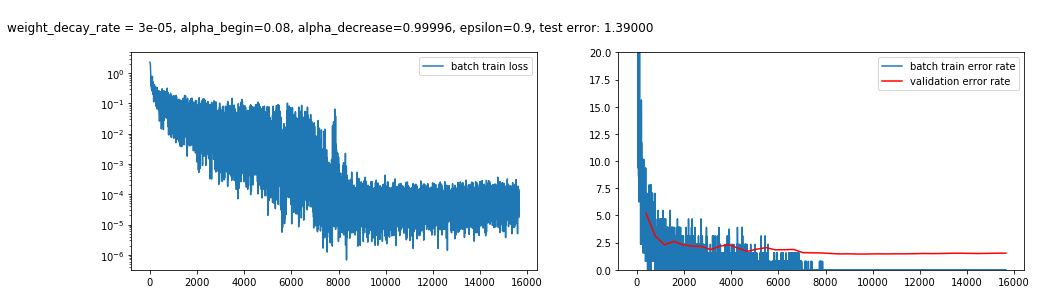

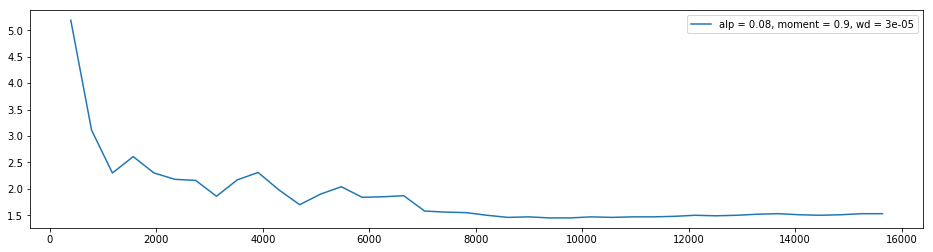

In [9]:
#
# Testing various momentums, weight decays, starting learning rates
#       
#


momentums = [0.9]
weight_decays = [0.00003]
alphas = [8*1e-2]
histories = []

#bests = [(0.9, 0.08, 0.00003)]  # (moment, alpha, wd)

for moment in momentums:
    for alp in alphas:
        for wd in weight_decays:
        
            model = FeedforwardNet(
            [
             AffineLayer(784, 700),
             ReLULayer(),
             AffineLayer(700, 600),
             ReLULayer(),
             AffineLayer(600, 500),
             ReLULayer(),
             AffineLayer(500, 10),
             SoftMaxLayer()
            ])
            
            # Initialize parameters
            for p in model.parameters:
                if p.name == 'W':
                    p.data.normal_(0, 0.02) 
                    #p.data = p.data / np.sqrt(p.data.size()[0])
                    #p.data.uniform_(0.0, 0.04)
                elif p.name == 'b':
                    p.data.zero_() + 1e-2
                else:
                    raise ValueError('Unknown parameter name "%s"' % p.name)

            histories.append((SGD(model, mnist_loaders, alpha=alp, alpha_decrease=0.99996, num_epochs=40, patience_expansion=0.0,
            log_every=100, cuda=True, weight_decay_rate=wd, data_augment=False,
            epsilon_start=0.5, epsilon_100=moment, max_norm_len=0.0), alp, moment, wd))

            print "Test error rate: %.2f%%" % compute_error_rate(model, mnist_loaders['test'])


plt.figure()

for hist in histories:
    hist_err = np.array(hist[0]['val_errs'])
    plot(hist_err[:,0], hist_err[:,1], label='alp = {0}, moment = {1}, wd = {2}'.format(hist[1], hist[2], hist[3]))
    legend()


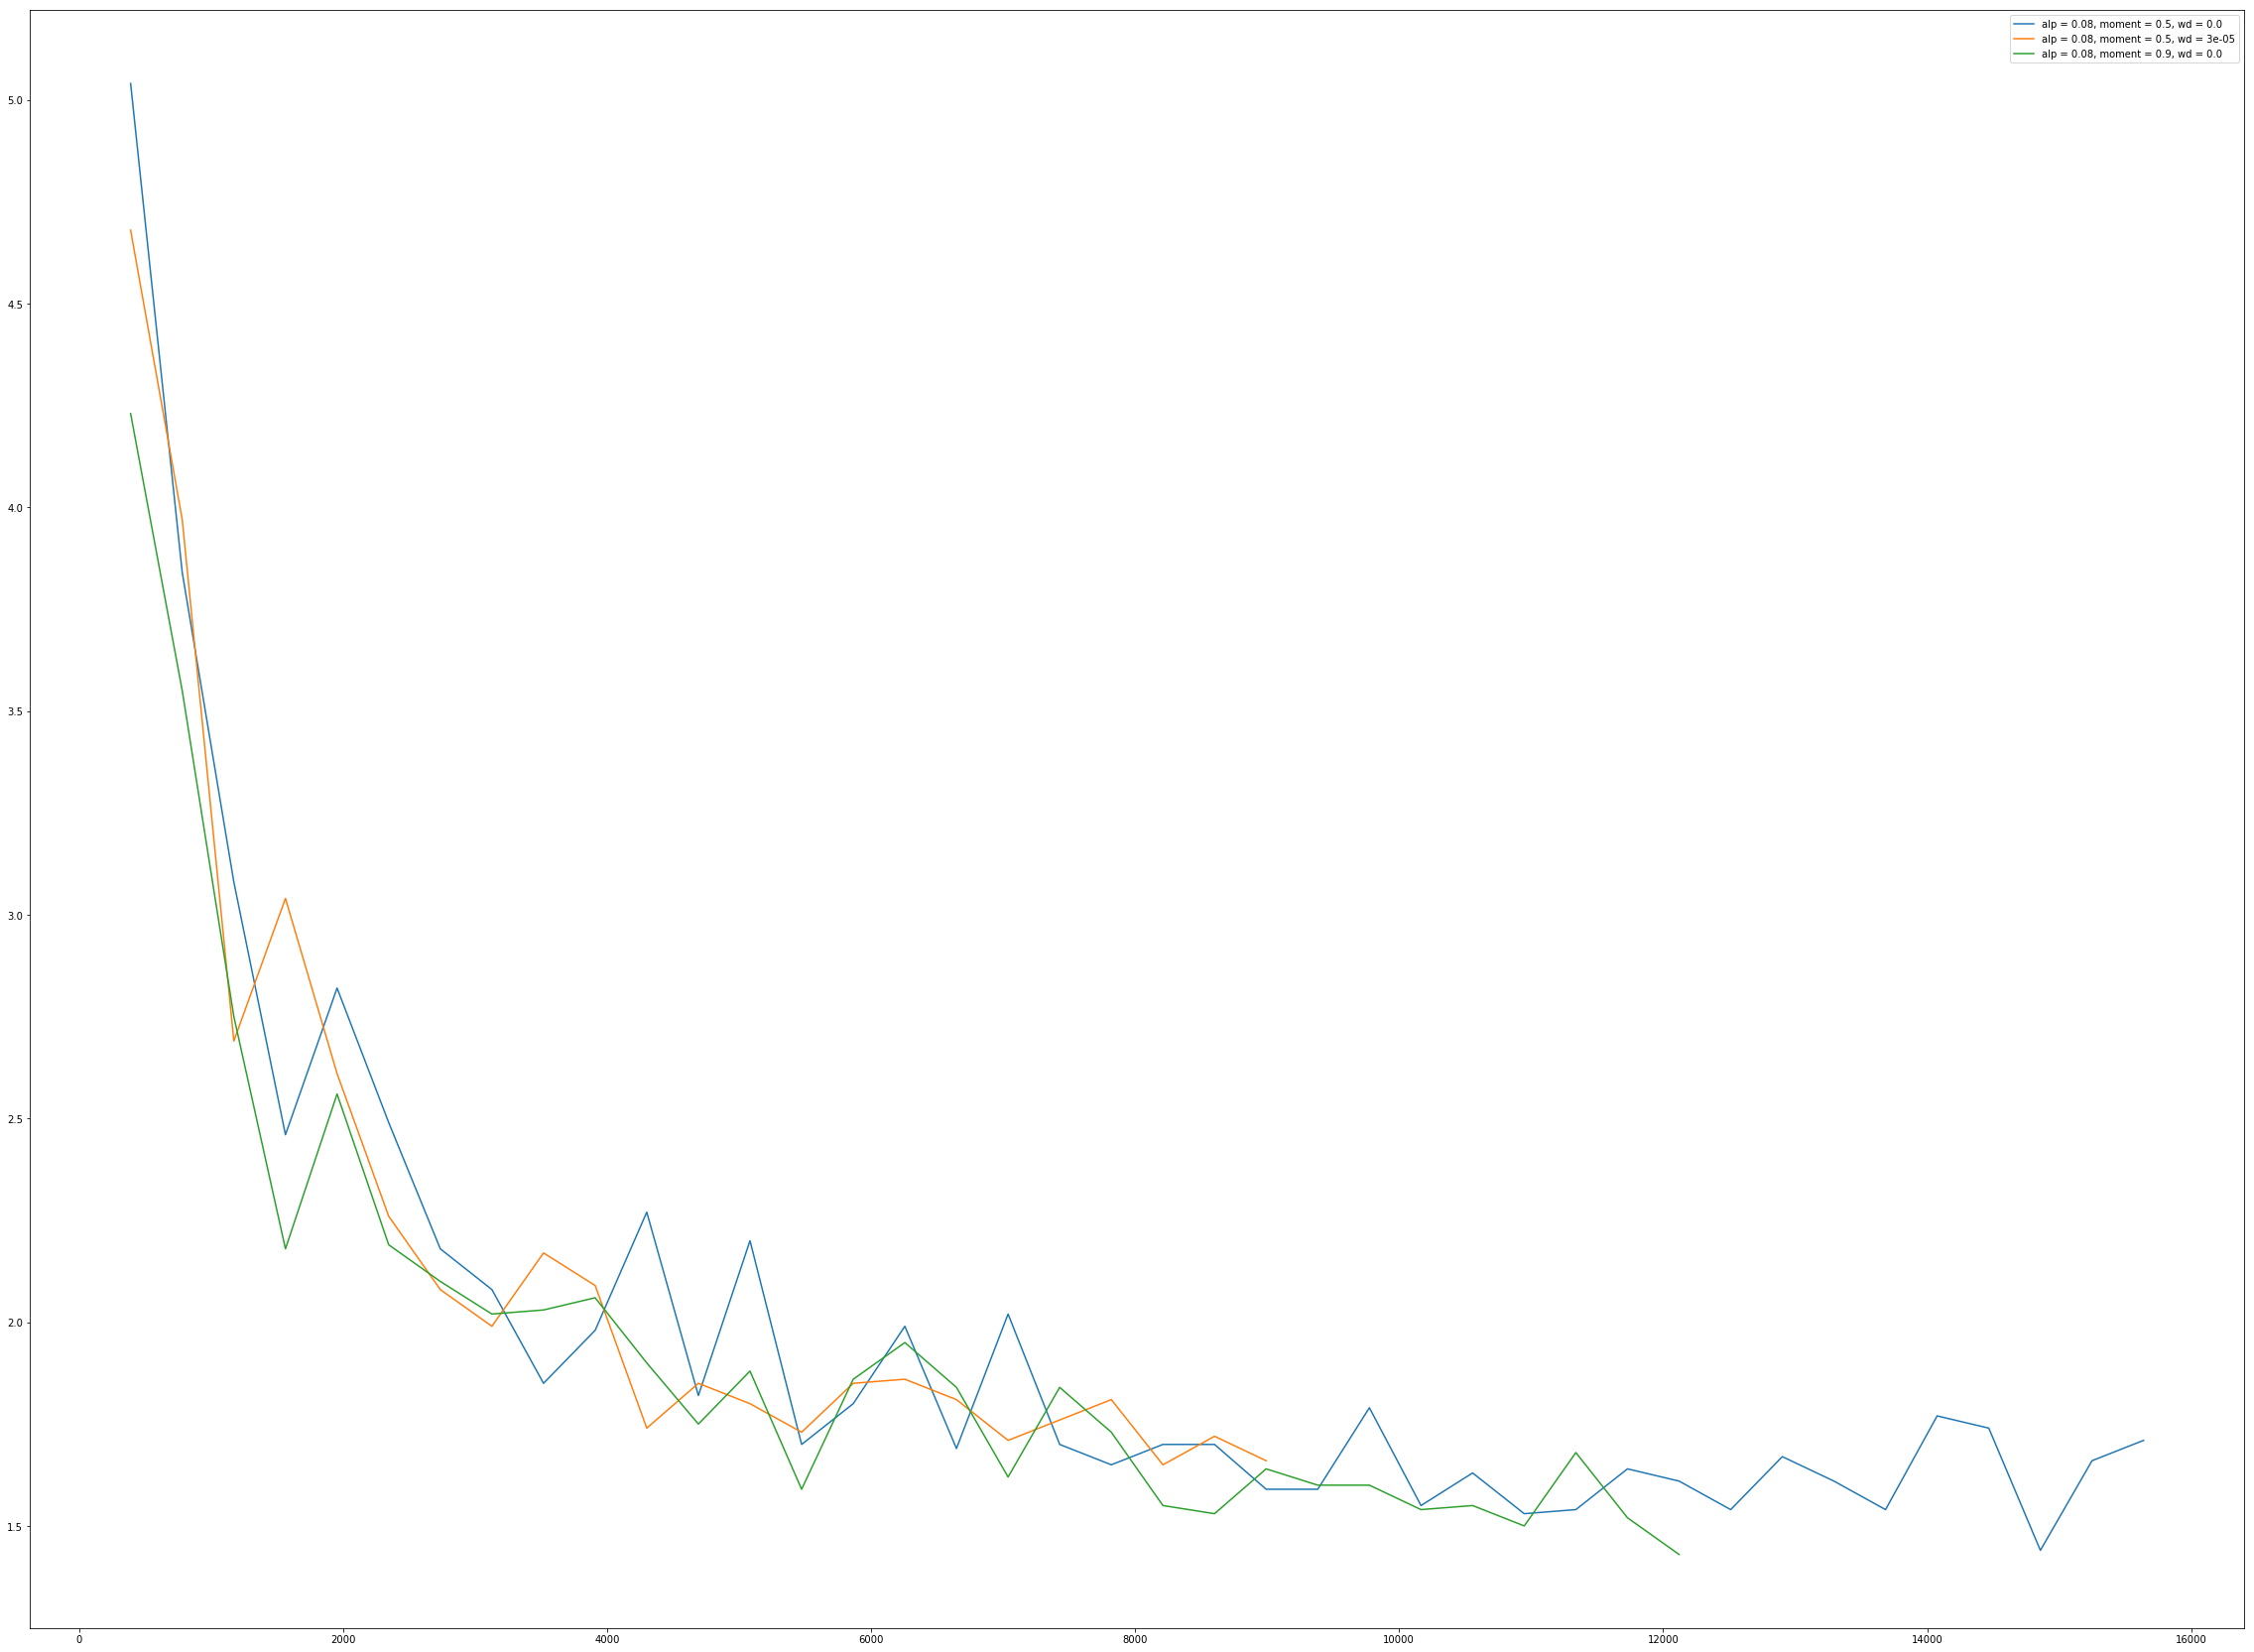

In [67]:
figsize(40,30)
plt.figure()

for hist in histories:
    hist_err = np.array(hist[0]['val_errs'])
    plot(hist_err[:,0], hist_err[:,1], label='alp = {0}, moment = {1}, wd = {2}'.format(hist[1], hist[2], hist[3]))
    legend()
    

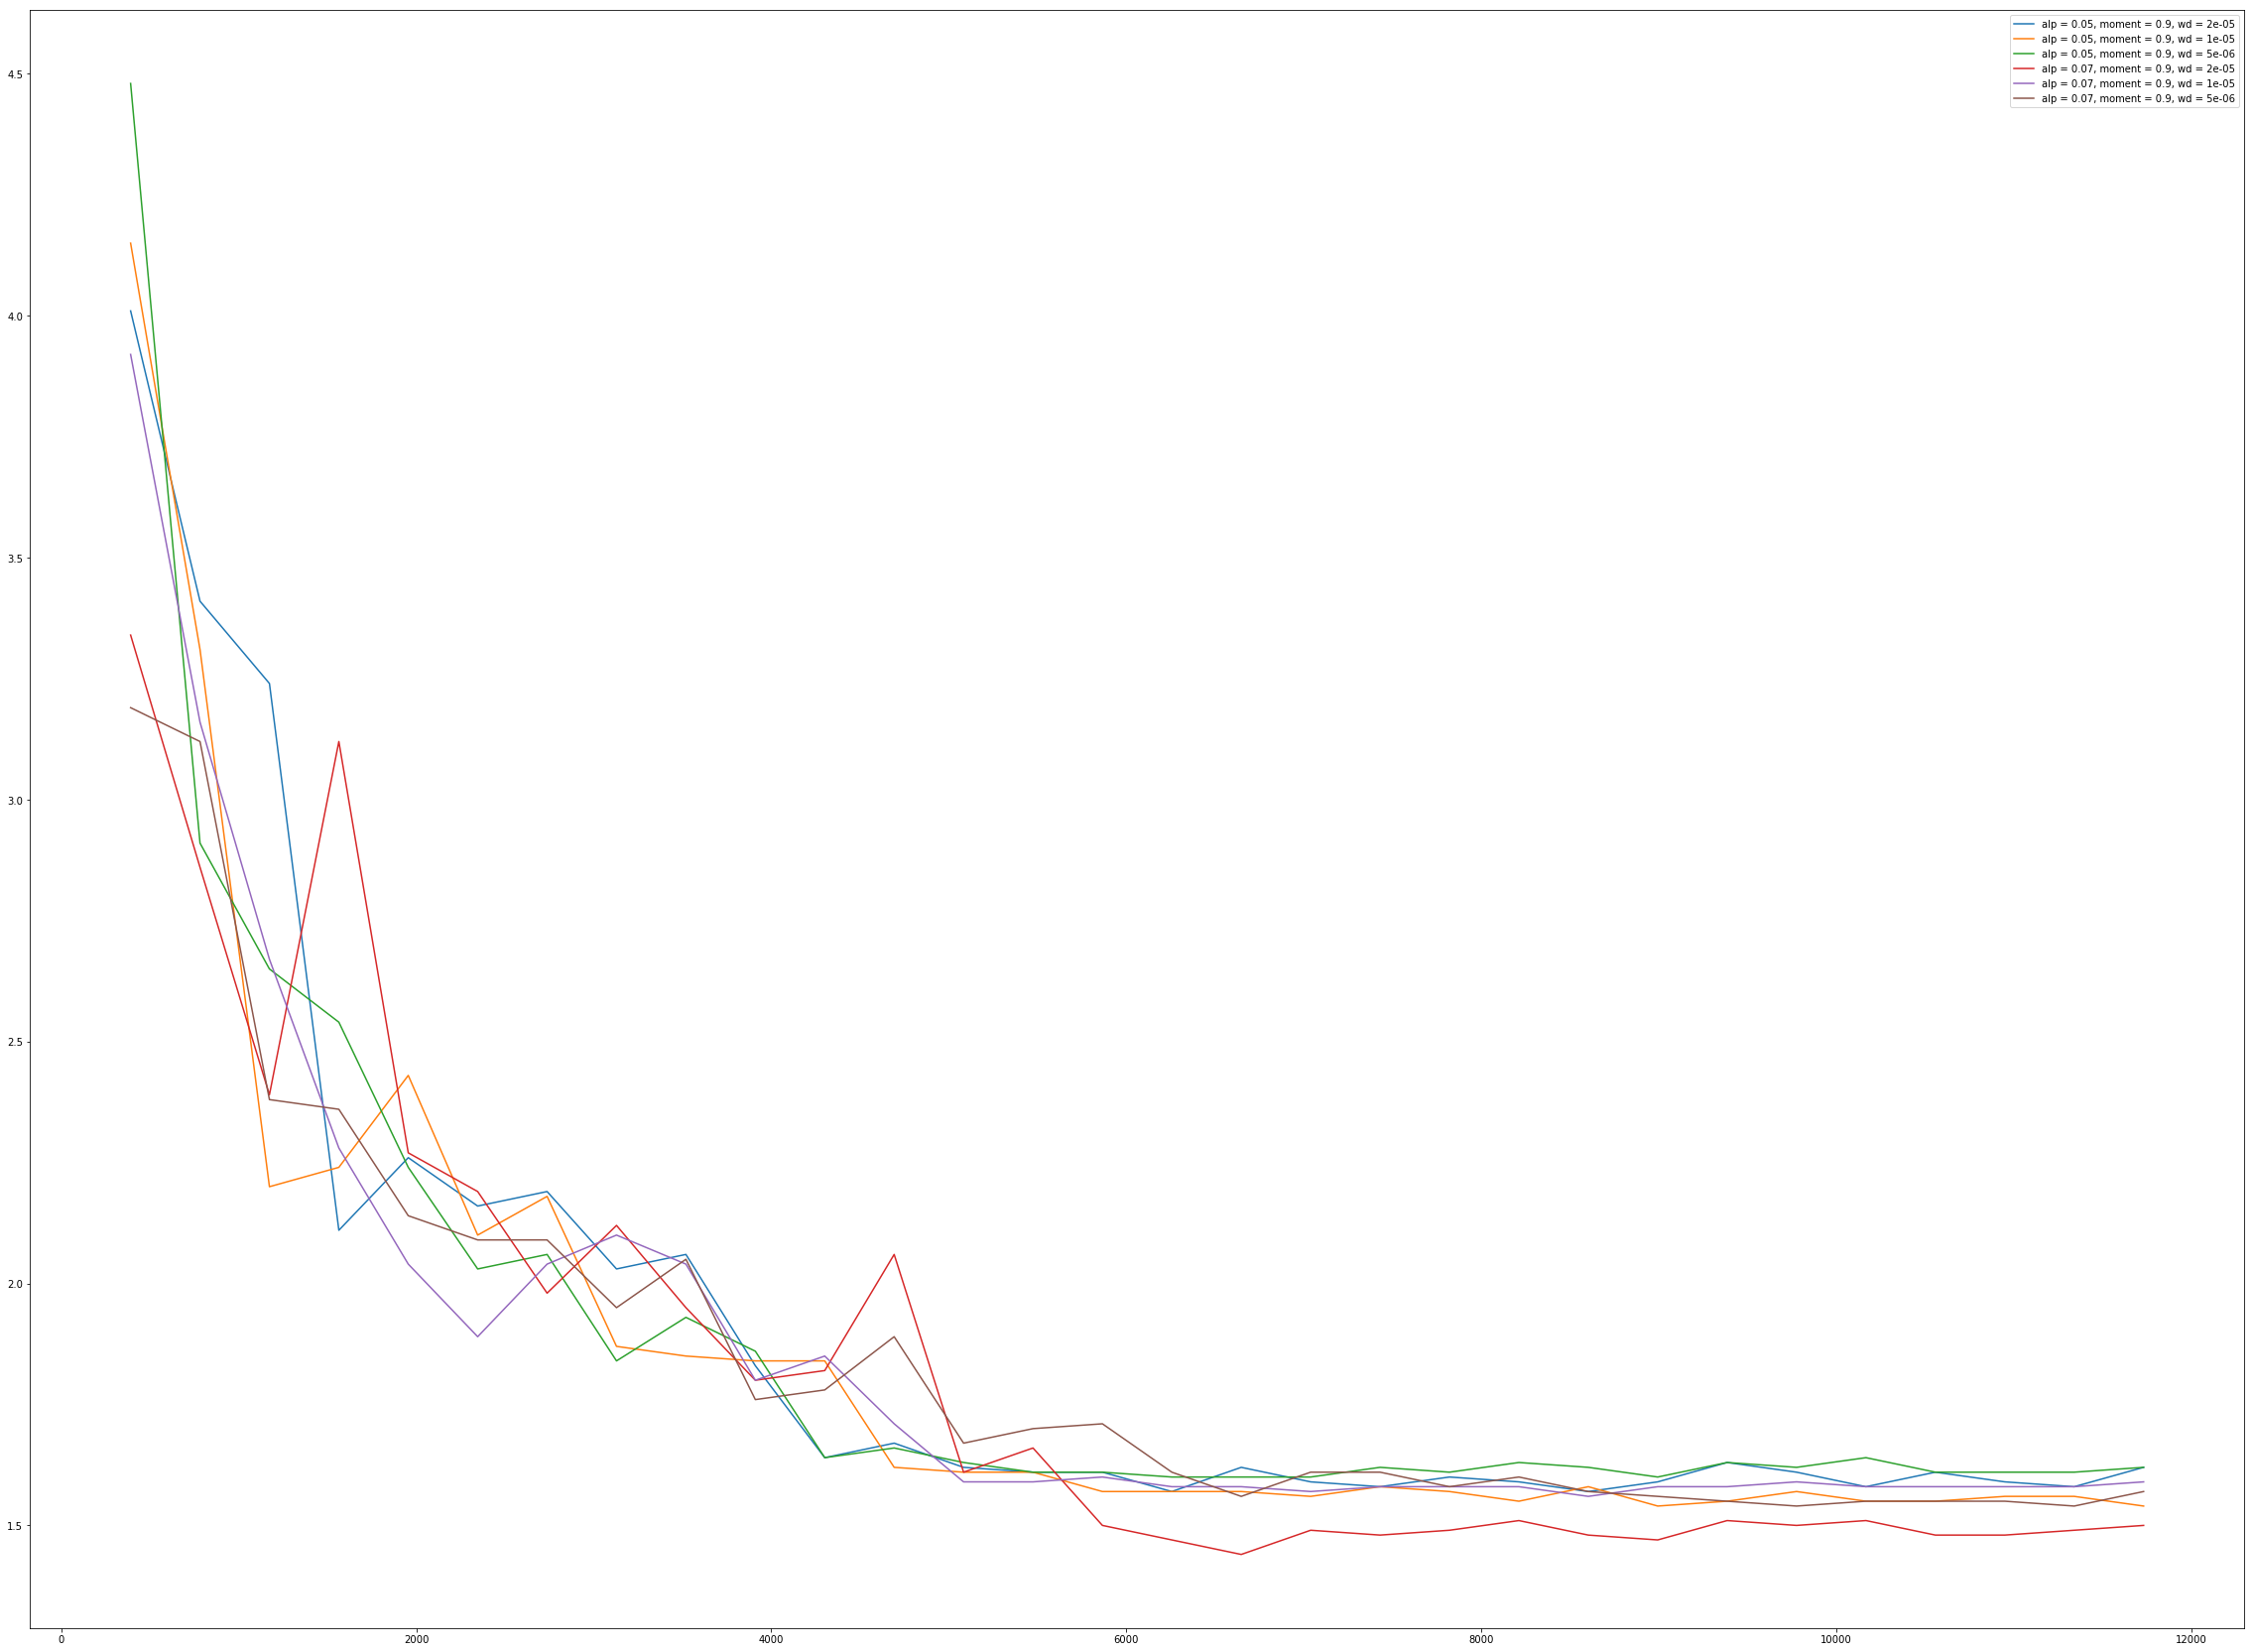

In [56]:
figsize(40,30)
plt.figure()

for hist in histories:
    hist_err = np.array(hist[0]['val_errs'])
    plot(hist_err[:,0], hist_err[:,1], label='alp = {0}, moment = {1}, wd = {2}'.format(hist[1], hist[2], hist[3]))
    legend()
    

Training the model!
Interrupt at any time to evaluate the best validation model so far.
Minibatch    100  | loss 0.1519083530 | err rate 3.1250000000%
Minibatch    200  | loss 0.2394464761 | err rate 8.5937500000%
Minibatch    300  | loss 0.1543523967 | err rate 7.0312500000%
----------------------------------------------------------
After epoch  1 | valid err rate:  4.22% | doing  50 epochs
----------------------------------------------------------
Test error rate: 4.19%
Minibatch    400  | loss 0.0664710775 | err rate 2.3437500000%
Minibatch    500  | loss 0.1074252427 | err rate 3.9062500000%
Minibatch    600  | loss 0.0447817259 | err rate 2.3437500000%
Minibatch    700  | loss 0.0848701522 | err rate 3.1250000000%
----------------------------------------------------------
After epoch  2 | valid err rate:  5.30% | doing  50 epochs
----------------------------------------------------------
Test error rate: 5.16%
Minibatch    800  | loss 0.0307890382 | err rate 0.7812500000%
Minibatc

Minibatch   7300  | loss 0.0001926683 | err rate 0.0000000000%
Minibatch   7400  | loss 0.0001068534 | err rate 0.0000000000%
----------------------------------------------------------
After epoch 19 | valid err rate:  1.59% | doing  50 epochs
----------------------------------------------------------
Test error rate: 1.45%
Minibatch   7500  | loss 0.0001795577 | err rate 0.0000000000%
Minibatch   7600  | loss 0.0000915040 | err rate 0.0000000000%
Minibatch   7700  | loss 0.0001054816 | err rate 0.0000000000%
Minibatch   7800  | loss 0.0002433160 | err rate 0.0000000000%
----------------------------------------------------------
After epoch 20 | valid err rate:  1.60% | doing  50 epochs
----------------------------------------------------------
Test error rate: 1.45%
Minibatch   7900  | loss 0.0002258759 | err rate 0.0000000000%
Minibatch   8000  | loss 0.0002506482 | err rate 0.0000000000%
Minibatch   8100  | loss 0.0002724386 | err rate 0.0000000000%
Minibatch   8200  | loss 0.000142

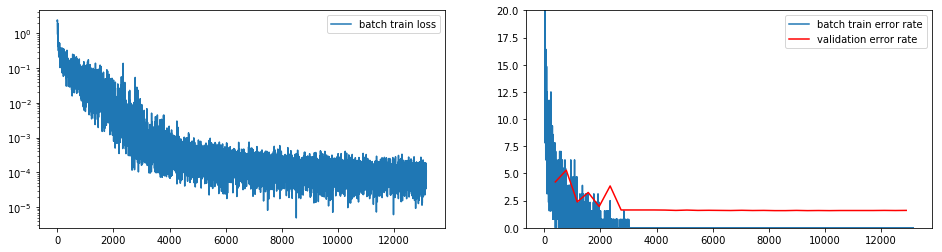

In [113]:
#
# momentum + weight decay(bad) + learning schedule
#       
#

model = FeedforwardNet(
    [
     AffineLayer(784, 700),
     ReLULayer(),
     AffineLayer(700, 600),
     ReLULayer(),
     AffineLayer(600, 500),
     ReLULayer(),
     AffineLayer(500, 10),
     SoftMaxLayer()
    ])

# Initialize parameters
for p in model.parameters:
    if p.name == 'W':
        p.data.normal_(0, 1) 
        p.data = p.data / sqrt(p.data.size()[0])
        #p.data.uniform_(0.0, 0.04)
    elif p.name == 'b':
        p.data.zero_() + 1e-2
    else:
        raise ValueError('Unknown parameter name "%s"' % p.name)

# On lab computers you can set cuda=True !
SGD(model, mnist_loaders, alpha=8*1e-2, cuda=True, num_epochs=50)

print "Test error rate: %.2f%%" % compute_error_rate(model, mnist_loaders['test'])

In [77]:


################
### Dropout ####
################



Training the model!
Interrupt at any time to evaluate the best validation model so far.
Minibatch    100  | loss 0.5263723135 | err rate 16.4062500000%
Minibatch    200  | loss 0.3948464692 | err rate 12.5000000000%
Minibatch    300  | loss 0.3338227868 | err rate 12.5000000000%
-----------------------------------------------------------
After epoch  1 | valid err rate:  4.79% | doing 8000 epochs
-----------------------------------------------------------
Test error rate: 4.71%
Minibatch    400  | loss 0.3155617118 | err rate 7.8125000000%
Minibatch    500  | loss 0.2541322410 | err rate 8.5937500000%
Minibatch    600  | loss 0.2201300859 | err rate 6.2500000000%
Minibatch    700  | loss 0.1556559801 | err rate 5.4687500000%
-----------------------------------------------------------
After epoch  2 | valid err rate:  3.38% | doing 8000 epochs
-----------------------------------------------------------
Test error rate: 3.53%
Minibatch    800  | loss 0.1236091331 | err rate 4.6875000000%

Minibatch   7200  | loss 0.0102596311 | err rate 0.0000000000%
Minibatch   7300  | loss 0.0610843226 | err rate 1.5625000000%
Minibatch   7400  | loss 0.0455698892 | err rate 1.5625000000%
-----------------------------------------------------------
After epoch 19 | valid err rate:  1.54% | doing 8000 epochs
-----------------------------------------------------------
Test error rate: 1.60%
Minibatch   7500  | loss 0.0182495229 | err rate 0.0000000000%
Minibatch   7600  | loss 0.0709071085 | err rate 3.1250000000%
Minibatch   7700  | loss 0.0944037139 | err rate 3.1250000000%
Minibatch   7800  | loss 0.0431329459 | err rate 0.7812500000%
-----------------------------------------------------------
After epoch 20 | valid err rate:  1.61% | doing 8000 epochs
-----------------------------------------------------------
Test error rate: 1.65%
Minibatch   7900  | loss 0.0661568642 | err rate 2.3437500000%
Minibatch   8000  | loss 0.0892834067 | err rate 3.9062500000%
Minibatch   8100  | loss 0.

-----------------------------------------------------------
After epoch 37 | valid err rate:  1.51% | doing 8000 epochs
-----------------------------------------------------------
Test error rate: 1.43%
Minibatch  14500  | loss 0.0098221619 | err rate 0.0000000000%
Minibatch  14600  | loss 0.0403333716 | err rate 1.5625000000%
Minibatch  14700  | loss 0.0300098360 | err rate 1.5625000000%
Minibatch  14800  | loss 0.0154991560 | err rate 0.0000000000%
-----------------------------------------------------------
After epoch 38 | valid err rate:  1.38% | doing 8000 epochs
-----------------------------------------------------------
Test error rate: 1.43%
Minibatch  14900  | loss 0.0017808866 | err rate 0.0000000000%
Minibatch  15000  | loss 0.0420704335 | err rate 0.7812500000%
Minibatch  15100  | loss 0.0260868259 | err rate 1.5625000000%
Minibatch  15200  | loss 0.0048767598 | err rate 0.0000000000%
-----------------------------------------------------------
After epoch 39 | valid err rat

Test error rate: 1.35%
Minibatch  21600  | loss 0.0590386316 | err rate 1.5625000000%
Minibatch  21700  | loss 0.0065078982 | err rate 0.0000000000%
Minibatch  21800  | loss 0.0697280914 | err rate 3.1250000000%
-----------------------------------------------------------
After epoch 56 | valid err rate:  1.33% | doing 8000 epochs
-----------------------------------------------------------
Test error rate: 1.22%
Minibatch  21900  | loss 0.0036153102 | err rate 0.0000000000%
Minibatch  22000  | loss 0.0207676329 | err rate 0.7812500000%
Minibatch  22100  | loss 0.0277243648 | err rate 0.7812500000%
Minibatch  22200  | loss 0.0220671948 | err rate 0.7812500000%
-----------------------------------------------------------
After epoch 57 | valid err rate:  1.32% | doing 8000 epochs
-----------------------------------------------------------
Test error rate: 1.22%
Minibatch  22300  | loss 0.0299628470 | err rate 1.5625000000%
Minibatch  22400  | loss 0.0862080008 | err rate 0.7812500000%
Mini

Minibatch  28800  | loss 0.0194272883 | err rate 0.7812500000%
Minibatch  28900  | loss 0.0117805190 | err rate 0.0000000000%
-----------------------------------------------------------
After epoch 74 | valid err rate:  1.28% | doing 8000 epochs
-----------------------------------------------------------
Test error rate: 1.34%
Minibatch  29000  | loss 0.0124993222 | err rate 0.7812500000%
Minibatch  29100  | loss 0.0544832088 | err rate 1.5625000000%
Minibatch  29200  | loss 0.0315030441 | err rate 0.7812500000%
Minibatch  29300  | loss 0.0134467799 | err rate 0.0000000000%
-----------------------------------------------------------
After epoch 75 | valid err rate:  1.25% | doing 8000 epochs
-----------------------------------------------------------
Test error rate: 1.31%
Minibatch  29400  | loss 0.0264313705 | err rate 0.7812500000%
Minibatch  29500  | loss 0.0117768422 | err rate 0.0000000000%
Minibatch  29600  | loss 0.0052873273 | err rate 0.0000000000%
Minibatch  29700  | loss 0.

Test error rate: 1.16%
Minibatch  36000  | loss 0.0060351659 | err rate 0.0000000000%
Minibatch  36100  | loss 0.0653025061 | err rate 3.1250000000%
Minibatch  36200  | loss 0.0166398641 | err rate 0.7812500000%
Minibatch  36300  | loss 0.0079963822 | err rate 0.7812500000%
-----------------------------------------------------------
After epoch 93 | valid err rate:  1.29% | doing 8000 epochs
-----------------------------------------------------------
Test error rate: 1.22%
Minibatch  36400  | loss 0.0063506891 | err rate 0.0000000000%
Minibatch  36500  | loss 0.0459200181 | err rate 0.7812500000%
Minibatch  36600  | loss 0.0014394586 | err rate 0.0000000000%
Minibatch  36700  | loss 0.0018421185 | err rate 0.0000000000%
-----------------------------------------------------------
After epoch 94 | valid err rate:  1.26% | doing 8000 epochs
-----------------------------------------------------------
Test error rate: 1.18%
Minibatch  36800  | loss 0.0241057575 | err rate 0.7812500000%
Mini

Minibatch  43200  | loss 0.0256760884 | err rate 1.5625000000%
Minibatch  43300  | loss 0.0010378720 | err rate 0.0000000000%
Minibatch  43400  | loss 0.0072845654 | err rate 0.0000000000%
------------------------------------------------------------
After epoch 111 | valid err rate:  1.30% | doing 8000 epochs
------------------------------------------------------------
Test error rate: 1.25%
Minibatch  43500  | loss 0.0225419290 | err rate 0.7812500000%
Minibatch  43600  | loss 0.0140444478 | err rate 0.7812500000%
Minibatch  43700  | loss 0.0132948980 | err rate 0.7812500000%
------------------------------------------------------------
After epoch 112 | valid err rate:  1.31% | doing 8000 epochs
------------------------------------------------------------
Test error rate: 1.14%
Minibatch  43800  | loss 0.0010981521 | err rate 0.0000000000%
Minibatch  43900  | loss 0.0129843354 | err rate 0.0000000000%
Minibatch  44000  | loss 0.0180065911 | err rate 0.7812500000%
Minibatch  44100  | l

Minibatch  50400  | loss 0.0276989732 | err rate 1.5625000000%
------------------------------------------------------------
After epoch 129 | valid err rate:  1.33% | doing 8000 epochs
------------------------------------------------------------
Test error rate: 1.13%
Minibatch  50500  | loss 0.0045644473 | err rate 0.0000000000%
Minibatch  50600  | loss 0.0136541855 | err rate 0.7812500000%
Minibatch  50700  | loss 0.0015400517 | err rate 0.0000000000%
Minibatch  50800  | loss 0.0102612525 | err rate 0.7812500000%
------------------------------------------------------------
After epoch 130 | valid err rate:  1.28% | doing 8000 epochs
------------------------------------------------------------
Test error rate: 1.17%
Minibatch  50900  | loss 0.0227769036 | err rate 0.7812500000%
Minibatch  51000  | loss 0.0046921913 | err rate 0.0000000000%
Minibatch  51100  | loss 0.0041263336 | err rate 0.0000000000%
Minibatch  51200  | loss 0.0004844103 | err rate 0.0000000000%
---------------------

Test error rate: 1.12%
Minibatch  57500  | loss 0.0011181604 | err rate 0.0000000000%
Minibatch  57600  | loss 0.0015816813 | err rate 0.0000000000%
Minibatch  57700  | loss 0.0350465067 | err rate 2.3437500000%
Minibatch  57800  | loss 0.0027793206 | err rate 0.0000000000%
------------------------------------------------------------
After epoch 148 | valid err rate:  1.24% | doing 8000 epochs
------------------------------------------------------------
Test error rate: 1.15%
Minibatch  57900  | loss 0.0069898707 | err rate 0.7812500000%
Minibatch  58000  | loss 0.0134678697 | err rate 0.7812500000%
Minibatch  58100  | loss 0.0090367720 | err rate 0.0000000000%
Minibatch  58200  | loss 0.0513345487 | err rate 0.7812500000%
------------------------------------------------------------
After epoch 149 | valid err rate:  1.24% | doing 8000 epochs
------------------------------------------------------------
Test error rate: 1.11%
Minibatch  58300  | loss 0.0011717853 | err rate 0.0000000000

Minibatch  64600  | loss 0.0023066443 | err rate 0.0000000000%
Minibatch  64700  | loss 0.0021150259 | err rate 0.0000000000%
Minibatch  64800  | loss 0.0084364256 | err rate 0.0000000000%
Minibatch  64900  | loss 0.0055179931 | err rate 0.0000000000%
------------------------------------------------------------
After epoch 166 | valid err rate:  1.15% | doing 8000 epochs
------------------------------------------------------------
Test error rate: 1.11%
Minibatch  65000  | loss 0.0178489517 | err rate 0.7812500000%
Minibatch  65100  | loss 0.0207551513 | err rate 0.7812500000%
Minibatch  65200  | loss 0.0178647805 | err rate 0.7812500000%
------------------------------------------------------------
After epoch 167 | valid err rate:  1.17% | doing 8000 epochs
------------------------------------------------------------
Test error rate: 1.17%
Minibatch  65300  | loss 0.0040151109 | err rate 0.0000000000%
Minibatch  65400  | loss 0.0237836614 | err rate 0.7812500000%
Minibatch  65500  | l

Minibatch  71800  | loss 0.0192380268 | err rate 0.7812500000%
Minibatch  71900  | loss 0.0114448043 | err rate 0.7812500000%
------------------------------------------------------------
After epoch 184 | valid err rate:  1.23% | doing 8000 epochs
------------------------------------------------------------
Test error rate: 1.12%
Minibatch  72000  | loss 0.0004073248 | err rate 0.0000000000%
Minibatch  72100  | loss 0.0009980256 | err rate 0.0000000000%
Minibatch  72200  | loss 0.0026278254 | err rate 0.0000000000%
Minibatch  72300  | loss 0.0032901838 | err rate 0.0000000000%
------------------------------------------------------------
After epoch 185 | valid err rate:  1.27% | doing 8000 epochs
------------------------------------------------------------
Test error rate: 1.13%
Minibatch  72400  | loss 0.0032710552 | err rate 0.0000000000%
Minibatch  72500  | loss 0.0124157974 | err rate 0.0000000000%
Minibatch  72600  | loss 0.0030823536 | err rate 0.0000000000%
Minibatch  72700  | l

------------------------------------------------------------
After epoch 202 | valid err rate:  1.22% | doing 8000 epochs
------------------------------------------------------------
Test error rate: 1.12%
Minibatch  79000  | loss 0.0145963170 | err rate 0.0000000000%
Minibatch  79100  | loss 0.0169065502 | err rate 0.7812500000%
Minibatch  79200  | loss 0.0001375598 | err rate 0.0000000000%
Minibatch  79300  | loss 0.0056523462 | err rate 0.0000000000%
------------------------------------------------------------
After epoch 203 | valid err rate:  1.22% | doing 8000 epochs
------------------------------------------------------------
Test error rate: 1.13%
Minibatch  79400  | loss 0.0047935033 | err rate 0.0000000000%
Minibatch  79500  | loss 0.0089455703 | err rate 0.0000000000%
Minibatch  79600  | loss 0.0093762102 | err rate 0.7812500000%
Minibatch  79700  | loss 0.0319748372 | err rate 0.7812500000%
------------------------------------------------------------
After epoch 204 | valid

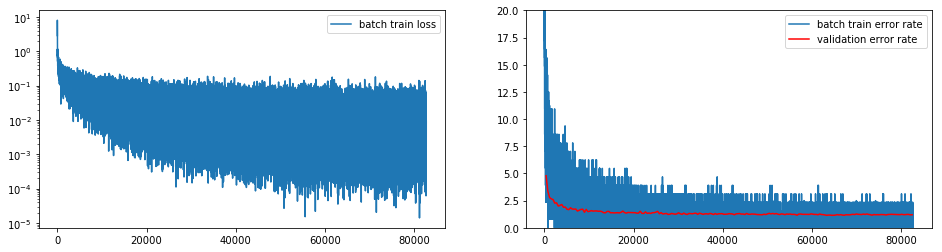

In [126]:
# DROPOUT + weight decay

model = FeedforwardNet(
    [
     DropoutLayer20(),   
     AffineLayer(784, 1200),
     DropoutLayer(),    
     ReLULayer(),
        
     AffineLayer(1200, 1200),
     DropoutLayer(),
     ReLULayer(),
        
     AffineLayer(1200, 1200),
     DropoutLayer(),
     ReLULayer(),
        
     AffineLayer(1200, 10),
     SoftMaxLayer()
    ])

# Initialize parameters
for p in model.parameters:
    if p.name == 'W':
        p.data.normal_(0, 1) 
        p.data = p.data / sqrt(p.data.size()[0])
        #p.data.uniform_(0.0, 0.04)
    elif p.name == 'b':
        p.data.zero_() + 1e-2
    else:
        raise ValueError('Unknown parameter name "%s"' % p.name)

# On lab computers you can set cuda=True !
SGD(model, mnist_loaders, alpha=1e-1, cuda=True, num_epochs = 8000)

print "Test error rate: %.2f%%" % compute_error_rate(model, mnist_loaders['test'])

Training the model!
Interrupt at any time to evaluate the best validation model so far.
Minibatch    100  | loss 1.2858501673 | err rate 45.3125000000% | epsilon 0.900
Minibatch    200  | loss 0.5197957158 | err rate 16.4062500000% | epsilon 0.900
Minibatch    300  | loss 0.4320828617 | err rate 12.5000000000% | epsilon 0.900
----------------------------------------------------------
After epoch  1 | valid err rate:  6.21% | doing  40 epochs
----------------------------------------------------------
Test error rate: 6.34%
Minibatch    400  | loss 0.2655506432 | err rate 8.5937500000% | epsilon 0.900
Minibatch    500  | loss 0.2700448334 | err rate 8.5937500000% | epsilon 0.900
Minibatch    600  | loss 0.2123840749 | err rate 7.0312500000% | epsilon 0.900
Minibatch    700  | loss 0.2623619735 | err rate 7.0312500000% | epsilon 0.900
----------------------------------------------------------
After epoch  2 | valid err rate:  4.15% | doing  40 epochs
--------------------------------------

Minibatch   6400  | loss 0.0869353116 | err rate 1.5625000000% | epsilon 0.900
Minibatch   6500  | loss 0.0659454241 | err rate 3.1250000000% | epsilon 0.900
Minibatch   6600  | loss 0.0807384625 | err rate 2.3437500000% | epsilon 0.900
----------------------------------------------------------
After epoch 17 | valid err rate:  1.74% | doing  40 epochs
----------------------------------------------------------
Test error rate: 1.82%
Minibatch   6700  | loss 0.0492807366 | err rate 1.5625000000% | epsilon 0.900
Minibatch   6800  | loss 0.1275724918 | err rate 3.9062500000% | epsilon 0.900
Minibatch   6900  | loss 0.0823483393 | err rate 2.3437500000% | epsilon 0.900
Minibatch   7000  | loss 0.0547544211 | err rate 1.5625000000% | epsilon 0.900
----------------------------------------------------------
After epoch 18 | valid err rate:  1.69% | doing  40 epochs
----------------------------------------------------------
Test error rate: 1.66%
Minibatch   7100  | loss 0.0460199751 | err rat

Minibatch  12800  | loss 0.0660858750 | err rate 1.5625000000% | epsilon 0.900
Minibatch  12900  | loss 0.0347265415 | err rate 0.7812500000% | epsilon 0.900
----------------------------------------------------------
After epoch 33 | valid err rate:  1.63% | doing  40 epochs
----------------------------------------------------------
Test error rate: 1.51%
Minibatch  13000  | loss 0.0533947423 | err rate 1.5625000000% | epsilon 0.900
Minibatch  13100  | loss 0.0554509051 | err rate 2.3437500000% | epsilon 0.900
Minibatch  13200  | loss 0.0098615065 | err rate 0.0000000000% | epsilon 0.900
----------------------------------------------------------
After epoch 34 | valid err rate:  1.49% | doing  40 epochs
----------------------------------------------------------
Test error rate: 1.45%
Minibatch  13300  | loss 0.0596793890 | err rate 3.1250000000% | epsilon 0.900
Minibatch  13400  | loss 0.0445273183 | err rate 0.7812500000% | epsilon 0.900
Minibatch  13500  | loss 0.0202821456 | err rat

Minibatch   3400  | loss 0.1135651916 | err rate 3.9062500000% | epsilon 0.900
Minibatch   3500  | loss 0.0886671543 | err rate 2.3437500000% | epsilon 0.900
----------------------------------------------------------
After epoch  9 | valid err rate:  2.03% | doing  40 epochs
----------------------------------------------------------
Test error rate: 1.99%
Minibatch   3600  | loss 0.2341129333 | err rate 7.8125000000% | epsilon 0.900
Minibatch   3700  | loss 0.0812447816 | err rate 3.1250000000% | epsilon 0.900
Minibatch   3800  | loss 0.0794794187 | err rate 3.9062500000% | epsilon 0.900
Minibatch   3900  | loss 0.0982887074 | err rate 3.1250000000% | epsilon 0.900
----------------------------------------------------------
After epoch 10 | valid err rate:  2.01% | doing  40 epochs
----------------------------------------------------------
Test error rate: 1.94%
Minibatch   4000  | loss 0.1121453792 | err rate 2.3437500000% | epsilon 0.900
Minibatch   4100  | loss 0.1561076045 | err rat

----------------------------------------------------------
After epoch 25 | valid err rate:  1.57% | doing  40 epochs
----------------------------------------------------------
Test error rate: 1.52%
Minibatch   9800  | loss 0.0678001195 | err rate 3.1250000000% | epsilon 0.900
Minibatch   9900  | loss 0.0630866438 | err rate 2.3437500000% | epsilon 0.900
Minibatch  10000  | loss 0.0490312316 | err rate 2.3437500000% | epsilon 0.900
Minibatch  10100  | loss 0.0328826196 | err rate 0.7812500000% | epsilon 0.900
----------------------------------------------------------
After epoch 26 | valid err rate:  1.51% | doing  40 epochs
----------------------------------------------------------
Test error rate: 1.57%
Minibatch  10200  | loss 0.0762255043 | err rate 2.3437500000% | epsilon 0.900
Minibatch  10300  | loss 0.0379858874 | err rate 0.7812500000% | epsilon 0.900
Minibatch  10400  | loss 0.1250399500 | err rate 3.9062500000% | epsilon 0.900
Minibatch  10500  | loss 0.0239764713 | err rat

----------------------------------------------------------
After epoch  1 | valid err rate:  4.41% | doing  40 epochs
----------------------------------------------------------
Test error rate: 5.11%
Minibatch    400  | loss 0.2722529471 | err rate 10.1562500000% | epsilon 0.900
Minibatch    500  | loss 0.2538971901 | err rate 8.5937500000% | epsilon 0.900
Minibatch    600  | loss 0.2837874293 | err rate 10.1562500000% | epsilon 0.900
Minibatch    700  | loss 0.1908094287 | err rate 7.0312500000% | epsilon 0.900
----------------------------------------------------------
After epoch  2 | valid err rate:  2.97% | doing  40 epochs
----------------------------------------------------------
Test error rate: 3.41%
Minibatch    800  | loss 0.0905291289 | err rate 2.3437500000% | epsilon 0.900
Minibatch    900  | loss 0.2071975172 | err rate 4.6875000000% | epsilon 0.900
Minibatch   1000  | loss 0.2815293372 | err rate 9.3750000000% | epsilon 0.900
Minibatch   1100  | loss 0.1963736713 | err r

Test error rate: 1.52%
Minibatch   6700  | loss 0.0768675879 | err rate 3.1250000000% | epsilon 0.900
Minibatch   6800  | loss 0.0590453930 | err rate 2.3437500000% | epsilon 0.900
Minibatch   6900  | loss 0.0730959475 | err rate 3.1250000000% | epsilon 0.900
Minibatch   7000  | loss 0.0425763838 | err rate 1.5625000000% | epsilon 0.900
----------------------------------------------------------
After epoch 18 | valid err rate:  1.66% | doing  40 epochs
----------------------------------------------------------
Test error rate: 1.57%
Minibatch   7100  | loss 0.0516728349 | err rate 3.1250000000% | epsilon 0.900
Minibatch   7200  | loss 0.1228611767 | err rate 3.9062500000% | epsilon 0.900
Minibatch   7300  | loss 0.0354282409 | err rate 0.7812500000% | epsilon 0.900
Minibatch   7400  | loss 0.1054165587 | err rate 2.3437500000% | epsilon 0.900
----------------------------------------------------------
After epoch 19 | valid err rate:  1.71% | doing  40 epochs
---------------------------

Minibatch  13000  | loss 0.0548385642 | err rate 1.5625000000% | epsilon 0.900
Minibatch  13100  | loss 0.0132807866 | err rate 0.0000000000% | epsilon 0.900
Minibatch  13200  | loss 0.0707553327 | err rate 2.3437500000% | epsilon 0.900
----------------------------------------------------------
After epoch 34 | valid err rate:  1.46% | doing  40 epochs
----------------------------------------------------------
Test error rate: 1.51%
Minibatch  13300  | loss 0.0089393537 | err rate 0.0000000000% | epsilon 0.900
Minibatch  13400  | loss 0.0307112448 | err rate 0.7812500000% | epsilon 0.900
Minibatch  13500  | loss 0.0150813609 | err rate 0.0000000000% | epsilon 0.900
Minibatch  13600  | loss 0.0524262637 | err rate 2.3437500000% | epsilon 0.900
----------------------------------------------------------
After epoch 35 | valid err rate:  1.52% | doing  40 epochs
----------------------------------------------------------
Test error rate: 1.41%
Minibatch  13700  | loss 0.0511704870 | err rat

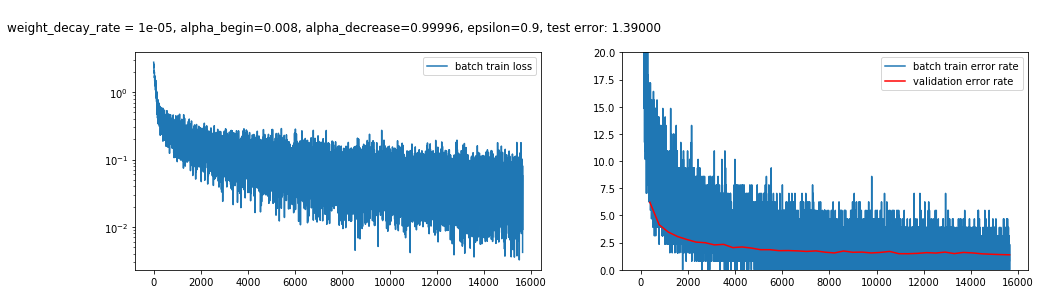

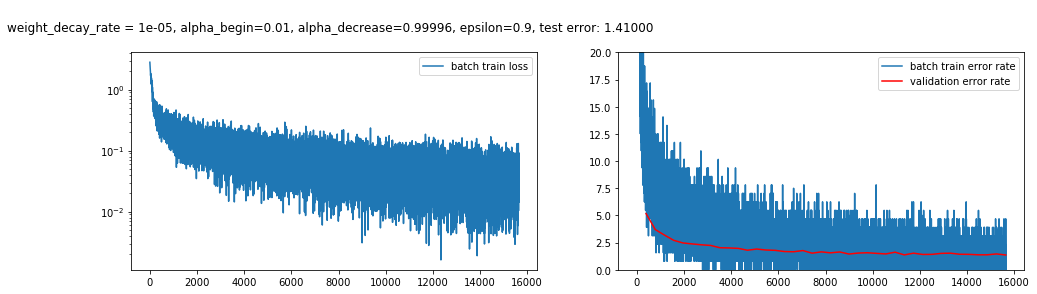

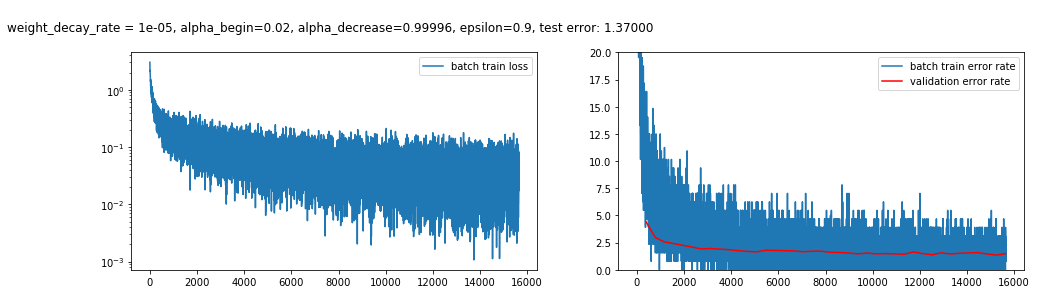

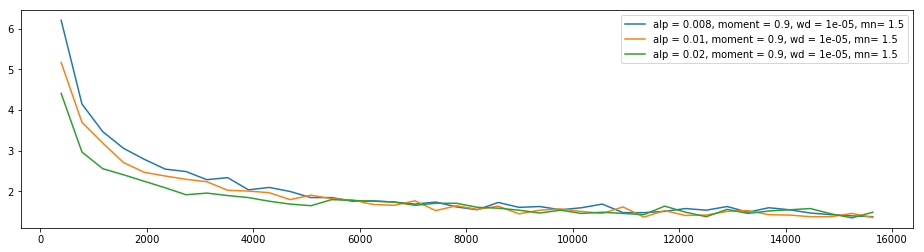

In [55]:
# DROPOUT + weight decay


#bests = [(0.9, 0.08, 0.00003)]  # (moment, alpha, wd)
#
# Testing various momentums, weight decays, starting learning rates
#       
#


momentums = [0.9]
weight_decays = [0.00001]
max_norms = [1.5] #0.7, 1.0, 1.5
alphas = [2*1e-2]
histories = []

#bests = [(0.9, 0.08, 0.0003)]  # (moment, alpha, wd)

for moment in momentums:
    for alp in alphas:
        for wd in weight_decays:
            for mn in max_norms:
                model = FeedforwardNet(
                [
                 DropoutLayer20(),   
                 AffineLayer(784, 1200),
                 DropoutLayer(),    
                 ReLULayer(),

                 AffineLayer(1200, 1200),
                 DropoutLayer(),
                 ReLULayer(),

                 AffineLayer(1200, 10),
                 SoftMaxLayer()
                ])

                # Initialize parameters
                for p in model.parameters:
                    if p.name == 'W':
                        p.data.normal_(0, 1) 
                        p.data = p.data / np.sqrt(p.data.size()[0])
                        #p.data.uniform_(0.0, 0.04)
                    elif p.name == 'b':
                        p.data.zero_() + 1e-2
                    else:
                        raise ValueError('Unknown parameter name "%s"' % p.name)

                histories.append((SGD(model, mnist_loaders, alpha=alp, alpha_decrease=0.99996, num_epochs=40, patience_expansion=0.0,
                log_every=100, cuda=True, weight_decay_rate=wd, data_augment=False,
                epsilon_start=0.0, epsilon_100=moment, max_norm_len=mn), alp, moment, wd, mn))

                print "Test error rate: %.2f%%" % compute_error_rate(model, mnist_loaders['test'])


plt.figure()

for hist in histories:
    hist_err = np.array(hist[0]['val_errs'])
    plot(hist_err[:,0], hist_err[:,1], label='alp = {0}, moment = {1}, wd = {2}, mn= {3}'.format(hist[1], hist[2], hist[3], hist[4]))
    legend()


In [59]:
# DROPOUT + weight decay


#bests = [(0.9, 0.08, 0.00003)]  # (moment, alpha, wd)
#
# Testing various momentums, weight decays, starting learning rates
#       
#


momentums = [0.9]
weight_decays = [0.00001]
max_norms = [1.5] #0.7, 1.0, 1.5
alphas = [2*1e-2]
histories = []

#bests = [(0.9, 0.08, 0.0003)]  # (moment, alpha, wd)

for moment in momentums:
    for alp in alphas:
        for wd in weight_decays:
            for mn in max_norms:
                model = FeedforwardNet(
                [
                 DropoutLayer20(),   
                 AffineLayer(784, 1200),
                 DropoutLayer(),    
                 ReLULayer(),

                 AffineLayer(1200, 1200),
                 DropoutLayer(),
                 ReLULayer(),
                    
                 AffineLayer(1200, 1200),
                 DropoutLayer(),
                 ReLULayer(),

                 AffineLayer(1200, 10),
                 SoftMaxLayer()
                ])

                # Initialize parameters
                for p in model.parameters:
                    if p.name == 'W':
                        p.data.normal_(0, 0.05) 
                        #p.data = p.data / np.sqrt(p.data.size()[0])
                        #p.data.uniform_(0.0, 0.04)
                    elif p.name == 'b':
                        p.data.zero_() + 1e-2
                    else:
                        raise ValueError('Unknown parameter name "%s"' % p.name)

                histories.append((SGD(model, mnist_loaders, alpha=alp, alpha_decrease=0.99996, num_epochs=40, patience_expansion=0.0,
                log_every=100, cuda=True, weight_decay_rate=wd, data_augment=False,
                epsilon_start=0.0, epsilon_100=moment, max_norm_len=mn), alp, moment, wd, mn))

                print "Test error rate: %.2f%%" % compute_error_rate(model, mnist_loaders['test'])


plt.figure()

for hist in histories:
    hist_err = np.array(hist[0]['val_errs'])
    plot(hist_err[:,0], hist_err[:,1], label='alp = {0}, moment = {1}, wd = {2}, mn= {3}'.format(hist[1], hist[2], hist[3], hist[4]))
    legend()


28.0
34.6410161514
34.6410161514
34.6410161514
Training the model!
Interrupt at any time to evaluate the best validation model so far.
Minibatch    100  | loss 1.2960453033 | err rate 41.4062500000% | epsilon 0.900
Minibatch    200  | loss 0.8067175746 | err rate 18.7500000000% | epsilon 0.900
Minibatch    300  | loss 0.2788649797 | err rate 10.1562500000% | epsilon 0.900


TypeError: torch.addmm received an invalid combination of arguments - got (int, torch.FloatTensor, int, torch.FloatTensor, torch.cuda.FloatTensor, out=torch.FloatTensor), but expected one of:
 * (torch.FloatTensor source, torch.FloatTensor mat1, torch.FloatTensor mat2, *, torch.FloatTensor out)
 * (torch.FloatTensor source, torch.SparseFloatTensor mat1, torch.FloatTensor mat2, *, torch.FloatTensor out)
 * (float beta, torch.FloatTensor source, torch.FloatTensor mat1, torch.FloatTensor mat2, *, torch.FloatTensor out)
 * (torch.FloatTensor source, float alpha, torch.FloatTensor mat1, torch.FloatTensor mat2, *, torch.FloatTensor out)
 * (float beta, torch.FloatTensor source, torch.SparseFloatTensor mat1, torch.FloatTensor mat2, *, torch.FloatTensor out)
 * (torch.FloatTensor source, float alpha, torch.SparseFloatTensor mat1, torch.FloatTensor mat2, *, torch.FloatTensor out)
 * (float beta, torch.FloatTensor source, float alpha, torch.FloatTensor mat1, torch.FloatTensor mat2, *, torch.FloatTensor out)
      didn't match because some of the arguments have invalid types: ([32;1mint[0m, [32;1mtorch.FloatTensor[0m, [32;1mint[0m, [32;1mtorch.FloatTensor[0m, [31;1mtorch.cuda.FloatTensor[0m, [32;1mout=torch.FloatTensor[0m)
 * (float beta, torch.FloatTensor source, float alpha, torch.SparseFloatTensor mat1, torch.FloatTensor mat2, *, torch.FloatTensor out)
      didn't match because some of the arguments have invalid types: ([32;1mint[0m, [32;1mtorch.FloatTensor[0m, [32;1mint[0m, [31;1mtorch.FloatTensor[0m, [31;1mtorch.cuda.FloatTensor[0m, [32;1mout=torch.FloatTensor[0m)


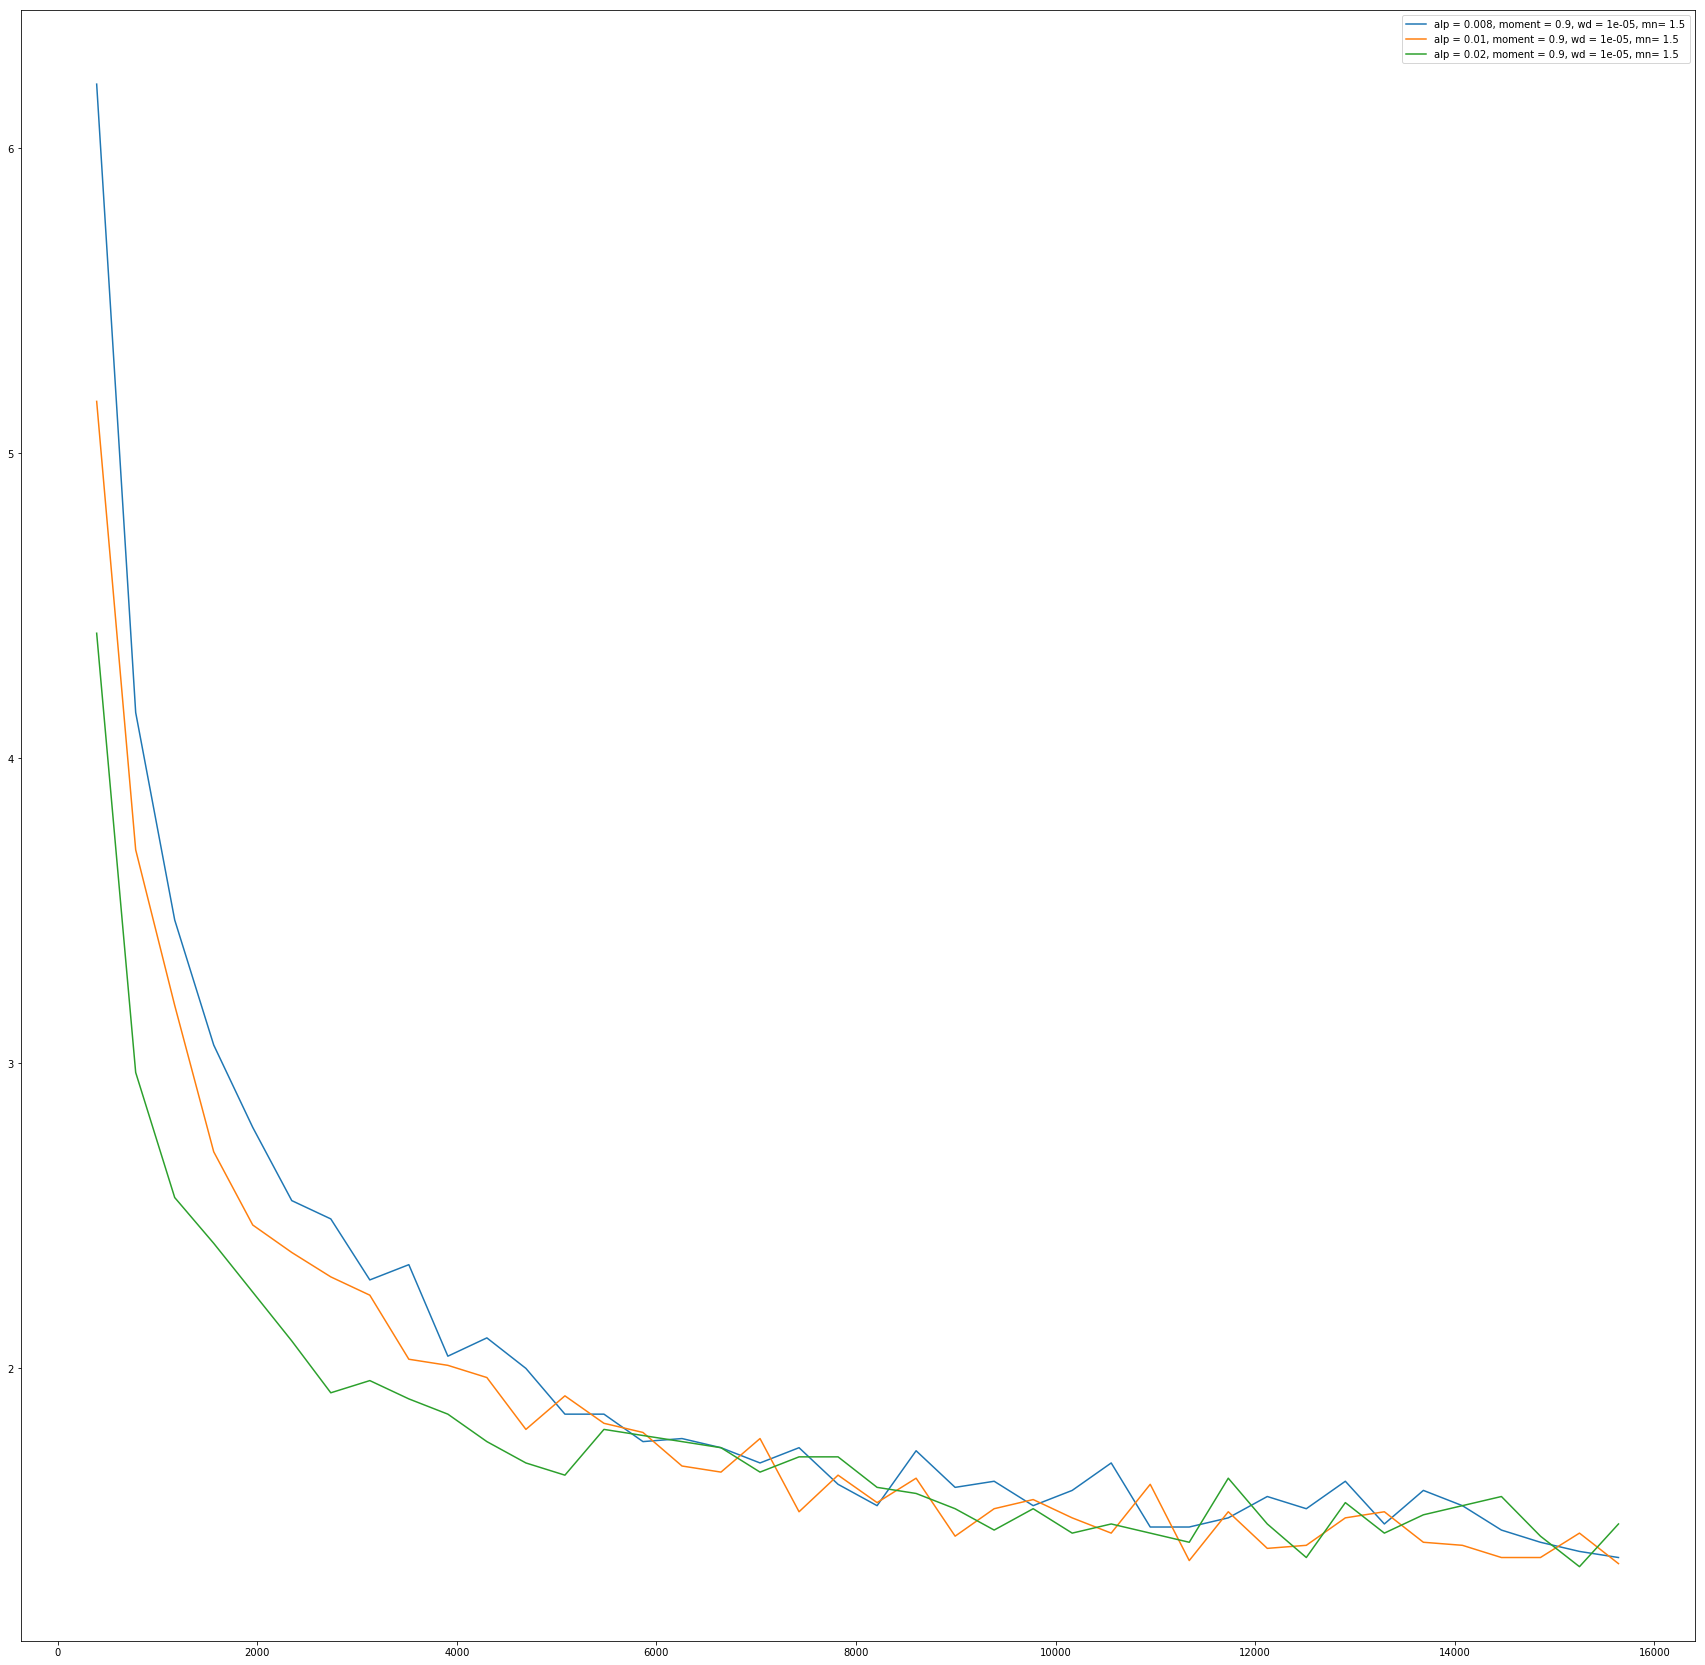

In [56]:
figsize(30,30)
plt.figure()

for hist in histories:
    hist_err = np.array(hist[0]['val_errs'])
    plot(hist_err[:,0], hist_err[:,1], label='alp = {0}, moment = {1}, wd = {2}, mn= {3}'.format(hist[1], hist[2], hist[3], hist[4]))
    legend()

Training the model!
Interrupt at any time to evaluate the best validation model so far.
Minibatch    100  | loss 0.1617521942 | err rate 4.6875000000% | epsilon 0.900
Minibatch    200  | loss 0.1023044512 | err rate 3.1250000000% | epsilon 0.900
Minibatch    300  | loss 0.1004465595 | err rate 3.1250000000% | epsilon 0.900
----------------------------------------------------------
After epoch  1 | valid err rate:  3.67% | doing  40 epochs
----------------------------------------------------------
Test error rate: 3.69%
Minibatch    400  | loss 0.0916956887 | err rate 3.1250000000% | epsilon 0.900
Minibatch    500  | loss 0.0942744464 | err rate 2.3437500000% | epsilon 0.900
Minibatch    600  | loss 0.2446626872 | err rate 6.2500000000% | epsilon 0.900
Minibatch    700  | loss 0.0432364680 | err rate 0.7812500000% | epsilon 0.900
----------------------------------------------------------
After epoch  2 | valid err rate:  3.16% | doing  40 epochs
-----------------------------------------

Minibatch   6400  | loss 0.0002335790 | err rate 0.0000000000% | epsilon 0.900
Minibatch   6500  | loss 0.0008368701 | err rate 0.0000000000% | epsilon 0.900
Minibatch   6600  | loss 0.0003786249 | err rate 0.0000000000% | epsilon 0.900
----------------------------------------------------------
After epoch 17 | valid err rate:  1.66% | doing  40 epochs
----------------------------------------------------------
Test error rate: 1.69%
Minibatch   6700  | loss 0.0004683860 | err rate 0.0000000000% | epsilon 0.900
Minibatch   6800  | loss 0.0030351544 | err rate 0.0000000000% | epsilon 0.900
Minibatch   6900  | loss 0.0000019391 | err rate 0.0000000000% | epsilon 0.900
Minibatch   7000  | loss 0.0000285358 | err rate 0.0000000000% | epsilon 0.900
----------------------------------------------------------
After epoch 18 | valid err rate:  1.52% | doing  40 epochs
----------------------------------------------------------
Test error rate: 1.56%
Minibatch   7100  | loss 0.0002478963 | err rat

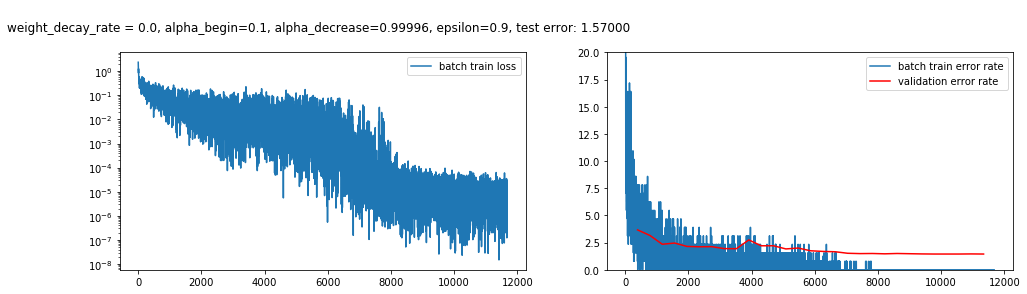

In [105]:
#
# BatchNorm
#

model = FeedforwardNet(
    [
     AffineLayer(784, 700),
     ReLULayer(),
     AffineLayer(700, 600),
     ReLULayer(),
     AffineLayer(600, 500),
     ReLULayer(),
     AffineLayer(500, 10),
     SoftMaxLayer()
    ])

# Initialize parameters
for p in model.parameters:
    if p.name == 'W':
        p.data.normal_(0, 1) 
        p.data = p.data / sqrt(p.data.size()[0])
        #p.data.uniform_(0.0, 0.04)
    elif p.name == 'b':
        p.data.zero_() + 1e-2
    else:
        raise ValueError('Unknown parameter name "%s"' % p.name)

# On lab computers you can set cuda=True !
SGD(model, mnist_loaders, alpha=0.1, alpha_decrease=0.99996, num_epochs=40, patience_expansion=0.0,
                log_every=100, cuda=True, weight_decay_rate=0.0, data_augment=False,
                epsilon_start=0.5, epsilon_100=0.9, max_norm_len=0.0)

print "Test error rate: %.2f%%" % compute_error_rate(model, mnist_loaders['test'])

Training the model!
Interrupt at any time to evaluate the best validation model so far.
Minibatch    100  | loss 0.5326561928 | err rate 11.7187500000%
Minibatch    200  | loss 0.6623254418 | err rate 17.9687500000%
Minibatch    300  | loss 0.2726243138 | err rate 5.4687500000%
----------------------------------------------------------
After epoch  1 | valid err rate:  4.82% | doing 200 epochs
----------------------------------------------------------
Test error rate: 4.99%
Minibatch    400  | loss 0.2497514188 | err rate 6.2500000000%
Minibatch    500  | loss 0.1692989171 | err rate 5.4687500000%
Minibatch    600  | loss 0.2832377851 | err rate 10.1562500000%
Minibatch    700  | loss 0.2466444969 | err rate 7.0312500000%
----------------------------------------------------------
After epoch  2 | valid err rate:  4.15% | doing 200 epochs
----------------------------------------------------------
Test error rate: 4.14%
Minibatch    800  | loss 0.2368791103 | err rate 7.0312500000%
Minib

Minibatch   7300  | loss 0.0937208831 | err rate 3.1250000000%
Minibatch   7400  | loss 0.0735774040 | err rate 3.1250000000%
----------------------------------------------------------
After epoch 19 | valid err rate:  1.90% | doing 200 epochs
----------------------------------------------------------
Test error rate: 1.83%
Minibatch   7500  | loss 0.0461477041 | err rate 0.7812500000%
Minibatch   7600  | loss 0.0858425647 | err rate 3.9062500000%
Minibatch   7700  | loss 0.0660583898 | err rate 3.1250000000%
Minibatch   7800  | loss 0.1481353045 | err rate 6.2500000000%
----------------------------------------------------------
After epoch 20 | valid err rate:  1.81% | doing 200 epochs
----------------------------------------------------------
Test error rate: 2.04%
Minibatch   7900  | loss 0.0524969772 | err rate 1.5625000000%
Minibatch   8000  | loss 0.0408378318 | err rate 2.3437500000%
Minibatch   8100  | loss 0.0847655386 | err rate 2.3437500000%
Minibatch   8200  | loss 0.114240

Test error rate: 1.52%
Minibatch  14500  | loss 0.0877282023 | err rate 2.3437500000%
Minibatch  14600  | loss 0.1167327091 | err rate 2.3437500000%
Minibatch  14700  | loss 0.0517875291 | err rate 1.5625000000%
Minibatch  14800  | loss 0.1032598168 | err rate 3.9062500000%
----------------------------------------------------------
After epoch 38 | valid err rate:  1.58% | doing 200 epochs
----------------------------------------------------------
Test error rate: 1.43%
Minibatch  14900  | loss 0.0537722073 | err rate 2.3437500000%
Minibatch  15000  | loss 0.1526493579 | err rate 5.4687500000%
Minibatch  15100  | loss 0.1008983999 | err rate 3.1250000000%
Minibatch  15200  | loss 0.1169773936 | err rate 3.9062500000%
----------------------------------------------------------
After epoch 39 | valid err rate:  1.47% | doing 200 epochs
----------------------------------------------------------
Test error rate: 1.36%
Minibatch  15300  | loss 0.0879974216 | err rate 3.1250000000%
Minibatch 


Loading best params on validation set (epoch 50)



TypeError: torch.addmm received an invalid combination of arguments - got (int, torch.cuda.FloatTensor, int, torch.cuda.FloatTensor, torch.FloatTensor, out=torch.cuda.FloatTensor), but expected one of:
 * (torch.cuda.FloatTensor source, torch.cuda.FloatTensor mat1, torch.cuda.FloatTensor mat2, *, torch.cuda.FloatTensor out)
 * (torch.cuda.FloatTensor source, torch.cuda.sparse.FloatTensor mat1, torch.cuda.FloatTensor mat2, *, torch.cuda.FloatTensor out)
 * (float beta, torch.cuda.FloatTensor source, torch.cuda.FloatTensor mat1, torch.cuda.FloatTensor mat2, *, torch.cuda.FloatTensor out)
 * (torch.cuda.FloatTensor source, float alpha, torch.cuda.FloatTensor mat1, torch.cuda.FloatTensor mat2, *, torch.cuda.FloatTensor out)
 * (float beta, torch.cuda.FloatTensor source, torch.cuda.sparse.FloatTensor mat1, torch.cuda.FloatTensor mat2, *, torch.cuda.FloatTensor out)
 * (torch.cuda.FloatTensor source, float alpha, torch.cuda.sparse.FloatTensor mat1, torch.cuda.FloatTensor mat2, *, torch.cuda.FloatTensor out)
 * (float beta, torch.cuda.FloatTensor source, float alpha, torch.cuda.FloatTensor mat1, torch.cuda.FloatTensor mat2, *, torch.cuda.FloatTensor out)
      didn't match because some of the arguments have invalid types: ([32;1mint[0m, [32;1mtorch.cuda.FloatTensor[0m, [32;1mint[0m, [32;1mtorch.cuda.FloatTensor[0m, [31;1mtorch.FloatTensor[0m, [32;1mout=torch.cuda.FloatTensor[0m)
 * (float beta, torch.cuda.FloatTensor source, float alpha, torch.cuda.sparse.FloatTensor mat1, torch.cuda.FloatTensor mat2, *, torch.cuda.FloatTensor out)
      didn't match because some of the arguments have invalid types: ([32;1mint[0m, [32;1mtorch.cuda.FloatTensor[0m, [32;1mint[0m, [31;1mtorch.cuda.FloatTensor[0m, [31;1mtorch.FloatTensor[0m, [32;1mout=torch.cuda.FloatTensor[0m)


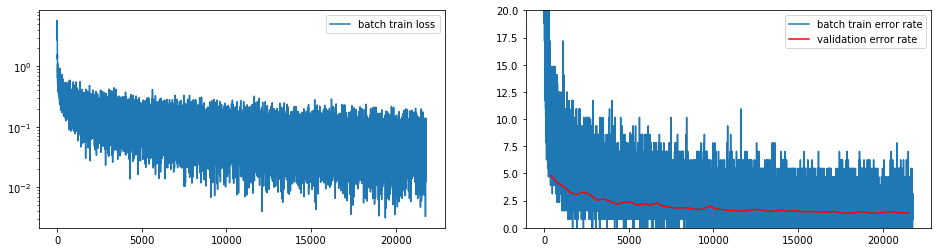

In [14]:
#
# DROPOUT + BatchNorm
#

model = FeedforwardNet(
    [
     DropoutLayer20(),   
     AffineLayer(784, 1000),
     BatchNormLayer(1000),
     DropoutLayer(),    
     ReLULayer(),
        
     AffineLayer(1000, 1000),
     BatchNormLayer(1000),
     DropoutLayer(),
     ReLULayer(),
        
     AffineLayer(1000, 1000),
     BatchNormLayer(1000),
     DropoutLayer(),
     ReLULayer(),
        
     AffineLayer(1000, 10),
     SoftMaxLayer()
    ])

# Initialize parameters
for p in model.parameters:
    if p.name == 'W':
        p.data.normal_(0, 1) 
        p.data = p.data / sqrt(p.data.size()[0])
        #p.data.uniform_(0.0, 0.04)
    elif p.name == 'b':
        p.data.zero_() + 1e-2
    else:
        raise ValueError('Unknown parameter name "%s"' % p.name)

# On lab computers you can set cuda=True !
SGD(model, mnist_loaders, alpha=1e-1, cuda=False, num_epochs = 200)

print "Test error rate: %.2f%%" % compute_error_rate(model, mnist_loaders['test'], cuda = True)

# Problem 3: Dropout [2p]

Implement a **dropout** layer and try to train a
network getting below 1.5% test error rates with dropout. The best
results with dropout are below 1%!

Remember to turn off dropout during testing, using `model.train_mode()` and `model.eval_mode()`!

Hint: Use [torch.nn.functional.dropout](http://pytorch.org/docs/master/nn.html#torch.nn.functional.dropout).

Details: http://arxiv.org/pdf/1207.0580.pdf.

# Problem 4: Data Augmentation [1p]

Apply data augmentation methods (e.g. rotations, noise, crops) when training networks on MNIST, to significantly reduce test error rate for your network. You can use functions from the [torchvision.transforms](http://pytorch.org/docs/master/torchvision/transforms.html) module.

# Problem 5: Batch Normalization [1p]

*Covariate shift* is a phenomenon associated with training deep models. Simply put, weight changes in early layers cause major changes in distribution of inputs to later layers, making it difficult to train later layers.

[Batch Normalization](https://arxiv.org/abs/1502.03167) addresses this problem by normalizing distributions of inputs to layers within mini-batches. It typically allows to train networks faster and/or with higher learning rates, lessens the importance
of initialization and might eliminate the need for Dropout.

Implement Batch Normalization and compare with regular training of MNIST models.

Remember to use the batch statistics during model training and to use an average of training batch statistics during model evaluation. For details please consult the paper.

# Problem 6: Norm Constraints [1p bonus]

Implement norm constraints, i.e. instead of weight decay, that tries to set 
all weights to small values, apply a limit on the total
norm of connections incoming to a neuron. In our case, this
corresponds to clipping the norm of *rows* of weight
matrices. An easy way of implementing it is to make a gradient
step, then look at the norm of rows and scale down those that are
over the threshold (this technique is called "projected gradient descent").

Please consult the Dropout paper (http://arxiv.org/pdf/1207.0580.pdf) for details.

# Problem 6: Polyak Averaging [1p bonus]

Implement Polyak averaging. For each parameter $\theta$
keep a separate, exponentially decayed average of the past values
$$
\bar{\theta}_n = \alpha_p\bar{\theta}_{n-1} + (1-\alpha_p)\theta_n.
$$
Use that average when evaluating the model on the test set.
Validate the approach by training a model on the MNIST dataset.

# Problem 7: Convolutional Network [2p bonus]

Use convolutional and max-pooling layers (`torch.nn.functional.conv2d`, `torch.nn.functional.max_pool2d`) and (without dropout) get a test error rate below 1.5%.

Training the model!
Interrupt at any time to evaluate the best validation model so far.
Minibatch    100  | loss 2.2150466442 | err rate 49.2187500000% | epsilon 0.900
Minibatch    200  | loss 0.3697052896 | err rate 12.5000000000% | epsilon 0.900
Minibatch    300  | loss 0.3903624117 | err rate 15.6250000000% | epsilon 0.900
----------------------------------------------------------
After epoch  1 | valid err rate: 11.70% | doing  30 epochs
----------------------------------------------------------
Test error rate: 12.02%
Minibatch    400  | loss 0.2568049431 | err rate 7.8125000000% | epsilon 0.900
Minibatch    500  | loss 0.2118575573 | err rate 7.8125000000% | epsilon 0.900
Minibatch    600  | loss 0.1618771106 | err rate 7.0312500000% | epsilon 0.900
Minibatch    700  | loss 0.2544050515 | err rate 10.9375000000% | epsilon 0.900
----------------------------------------------------------
After epoch  2 | valid err rate:  2.07% | doing  30 epochs
------------------------------------

Minibatch   6400  | loss 0.0001257242 | err rate 0.0000000000% | epsilon 0.900
Minibatch   6500  | loss 0.0002067160 | err rate 0.0000000000% | epsilon 0.900
Minibatch   6600  | loss 0.0002986302 | err rate 0.0000000000% | epsilon 0.900
----------------------------------------------------------
After epoch 17 | valid err rate:  0.98% | doing  30 epochs
----------------------------------------------------------
Test error rate: 0.81%
Minibatch   6700  | loss 0.0010656604 | err rate 0.0000000000% | epsilon 0.900
Minibatch   6800  | loss 0.0002694868 | err rate 0.0000000000% | epsilon 0.900
Minibatch   6900  | loss 0.0002084520 | err rate 0.0000000000% | epsilon 0.900
Minibatch   7000  | loss 0.0000139897 | err rate 0.0000000000% | epsilon 0.900
----------------------------------------------------------
After epoch 18 | valid err rate:  0.95% | doing  30 epochs
----------------------------------------------------------
Test error rate: 0.85%
Minibatch   7100  | loss 0.0000753534 | err rat

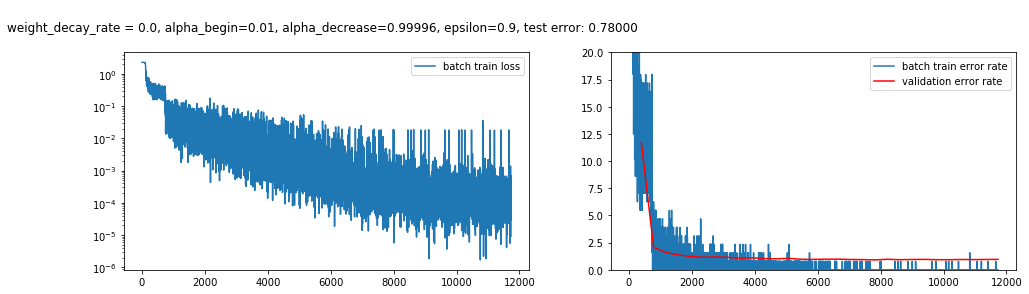

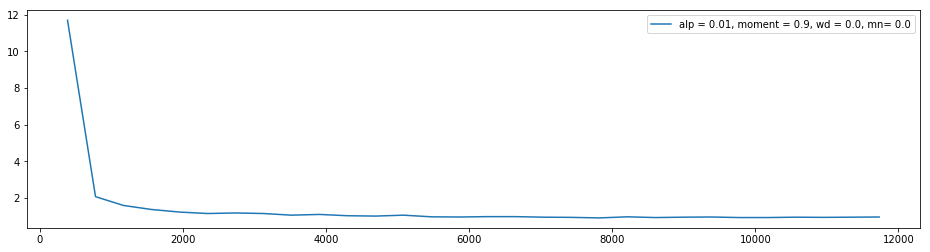

In [103]:
momentums = [0.9]
weight_decays = [0.0]
max_norms = [0.0] #0.7, 1.0, 1.5
alphas = [1e-2]
histories = []

#bests = [(0.9, 0.08, 0.0003)]  # (moment, alpha, wd)

for moment in momentums:
    for alp in alphas:
        for wd in weight_decays:
            for mn in max_norms:
                model = FeedforwardNet(
                [  
                 ConvLayer(1, 32, 5, 5),
                 ReLULayer(),
                 MaxPoolLayer(2, 32),
                 ConvLayer(32, 64, 5, 5),
                 ReLULayer(),
                 MaxPoolLayer(2, 64),
                 AffineLayer(7*7*64, 1024),   
                 ReLULayer(),   
                 AffineLayer(1024, 10),
                 ReLULayer(),
                 SoftMaxLayer()
                ])

                # Initialize parameters
                for p in model.parameters:
                    if p.name == 'W':
                        p.data.normal_(0, 0.02) 
                        #p.data = p.data / np.sqrt(p.data.size()[0])
                        #p.data.uniform_(0.0, 0.04)
                    elif p.name == 'Wconv':
                        p.data.normal_(0, 0.02) 
                    elif p.name == 'b':
                        p.data.zero_()
                    else:
                        raise ValueError('Unknown parameter name "%s"' % p.name)

                histories.append((SGD(model, mnist_loaders, alpha=alp, alpha_decrease=0.99996, num_epochs=30, patience_expansion=0.0,
                log_every=100, cuda=True, weight_decay_rate=wd, data_augment=False,
                epsilon_start=0.0, epsilon_100=moment, max_norm_len=mn), alp, moment, wd, mn))

                print "Test error rate: %.2f%%" % compute_error_rate(model, mnist_loaders['test'])


plt.figure()

for hist in histories:
    hist_err = np.array(hist[0]['val_errs'])
    plot(hist_err[:,0], hist_err[:,1], label='alp = {0}, moment = {1}, wd = {2}, mn= {3}'.format(hist[1], hist[2], hist[3], hist[4]))
    legend()

In [ ]:
momentums = [0.9]
weight_decays = [0.00005]
max_norms = [0.0] #0.7, 1.0, 1.5
alphas = [1e-2]
histories = []

#bests = [(0.9, 0.08, 0.0003)]  # (moment, alpha, wd)

for moment in momentums:
    for alp in alphas:
        for wd in weight_decays:
            for mn in max_norms:
                model = FeedforwardNet(
                [  
                 ConvLayer(1, 32, 5, 5),
                 ReLULayer(),
                 MaxPoolLayer(2, 32),
                 ConvLayer(32, 64, 5, 5),
                 ReLULayer(),
                 MaxPoolLayer(2, 64),
                 AffineLayer(7*7*64, 1024), 
                 DropoutLayer(),
                 ReLULayer(),   
                 AffineLayer(1024, 10),
                 ReLULayer(),
                 SoftMaxLayer()
                ])

                # Initialize parameters
                for p in model.parameters:
                    if p.name == 'W':
                        p.data.normal_(0, 0.04) 
                        #p.data = p.data / np.sqrt(p.data.size()[0])
                        #p.data.uniform_(0.0, 0.04)
                    elif p.name == 'Wconv':
                        p.data.normal_(0, 0.04) 
                    elif p.name == 'b':
                        p.data.zero_()
                    else:
                        raise ValueError('Unknown parameter name "%s"' % p.name)

                histories.append((SGD(model, mnist_loaders, alpha=alp, alpha_decrease=0.99996, num_epochs=30, patience_expansion=0.0,
                log_every=100, cuda=True, weight_decay_rate=wd, data_augment=False,
                epsilon_start=0.0, epsilon_100=moment, max_norm_len=mn), alp, moment, wd, mn))

                print "Test error rate: %.2f%%" % compute_error_rate(model, mnist_loaders['test'])


plt.figure()

for hist in histories:
    hist_err = np.array(hist[0]['val_errs'])
    plot(hist_err[:,0], hist_err[:,1], label='alp = {0}, moment = {1}, wd = {2}, mn= {3}'.format(hist[1], hist[2], hist[3], hist[4]))
    legend()

Training the model!
Interrupt at any time to evaluate the best validation model so far.
Minibatch    100  | loss 0.7826653719 | err rate 21.0937500000% | epsilon 0.900
Minibatch    200  | loss 0.2225873172 | err rate 7.0312500000% | epsilon 0.900
Minibatch    300  | loss 0.0553074181 | err rate 1.5625000000% | epsilon 0.900
----------------------------------------------------------
After epoch  1 | valid err rate:  2.31% | doing  30 epochs
----------------------------------------------------------
Test error rate: 2.33%
Minibatch    400  | loss 0.1063808650 | err rate 2.3437500000% | epsilon 0.900
Minibatch    500  | loss 0.0853140876 | err rate 3.9062500000% | epsilon 0.900
Minibatch    600  | loss 0.0768968388 | err rate 0.7812500000% | epsilon 0.900
Minibatch    700  | loss 0.0495390482 | err rate 2.3437500000% | epsilon 0.900
----------------------------------------------------------
After epoch  2 | valid err rate:  1.33% | doing  30 epochs
----------------------------------------

Minibatch   6400  | loss 0.0003809861 | err rate 0.0000000000% | epsilon 0.900
Minibatch   6500  | loss 0.0016110917 | err rate 0.0000000000% | epsilon 0.900
Minibatch   6600  | loss 0.0225901809 | err rate 0.7812500000% | epsilon 0.900
----------------------------------------------------------
After epoch 17 | valid err rate:  0.72% | doing  30 epochs
----------------------------------------------------------
Test error rate: 0.65%
Minibatch   6700  | loss 0.0008846881 | err rate 0.0000000000% | epsilon 0.900
Minibatch   6800  | loss 0.0010922519 | err rate 0.0000000000% | epsilon 0.900
Minibatch   6900  | loss 0.0044092741 | err rate 0.0000000000% | epsilon 0.900
Minibatch   7000  | loss 0.0075608087 | err rate 0.7812500000% | epsilon 0.900
----------------------------------------------------------
After epoch 18 | valid err rate:  0.77% | doing  30 epochs
----------------------------------------------------------
Test error rate: 0.63%
Minibatch   7100  | loss 0.0041880561 | err rat